In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib.colors as mcolors

In [ ]:
df = pd.read_csv('../data/wq_nli_results/BBU_raw_wqnli_results.csv')
df['log(p(entail|stereo))'] = df['p(entail|stereo)'].apply(np.log)
df['log(p(entail|counter))'] = df['p(entail|counter)'].apply(np.log)
df['log prob diff'] = df['log(p(entail|stereo))'] - df['log(p(entail|counter))']


In [ ]:
df_token_probs = pd.read_csv('../data/wq_tp_results/eval_bert_base_uncased_raw.csv')
df_token_probs['score_diff'] = df_token_probs['sent_more_score'] - df_token_probs['sent_less_score']

In [ ]:
def token_prob_boxplot(csv_path, model_name):
    # load data
    df_token_probs = pd.read_csv(csv_path)
    df_token_probs['score_diff'] = df_token_probs['sent_more_score'] - df_token_probs['sent_less_score']
    # predicate matching
    match_df_token_probs = pd.read_csv('../data/datasets_with_metadata/winoqueer_final_with_preds.csv')
    match_df_token_probs['pred_number'] = match_df_token_probs['pred_number'].astype('Int64')
    match_df_token_probs['category_num'] = match_df_token_probs['category_num'].astype('Int64')
    match_df_token_probs = match_df_token_probs.drop(columns=['Unnamed: 0'])
    # join token prob results with predicate label DF
    joined_results_token_prob = df_token_probs.merge(match_df_token_probs, left_index=True, right_index=True, how='inner', validate='1:1')
    joined_results_token_prob = joined_results_token_prob.drop(columns=['Unnamed: 0', 'sent_x', 'sent_y', 'Gender_ID_x', 'Gender_ID_y'])
    # reorder columns
    joined_results_token_prob = joined_results_token_prob[['sent_more', 'sent_less', 'bias_target_group',
                                             'pred_number', 'pred_text', 'category_num', 'category', 
                                             'sent_more_score', 'sent_less_score', 'score', 'score_diff']]
    # drop rows with NaN values in 'pred_number' and 'category_num' columns
    joined_results_token_prob = joined_results_token_prob.dropna(subset=['pred_number', 'category_num', 'pred_text', 'category'])

    # confidence interval for token prob
    res_token_prob = stats.bootstrap((joined_results_token_prob['score_diff'],),
                         np.median, confidence_level=0.95, n_resamples=10000, method='basic')
    
    # boxplot of token prob differences by category
    fig, ax = plt.subplots()
    ax.set_ylabel('difference in log(token probability) scores')

    cat_labels_token_prob = joined_results_token_prob['category'].unique()
    cat_labels_token_prob = ["all categories"] + sorted(cat_labels_token_prob.tolist())
    categories_token_prob = [joined_results_token_prob['score_diff']]
    for i in range(18):
        categories_token_prob.append(joined_results_token_prob[joined_results_token_prob['category_num'] == i]['score_diff'].values)

    bplot = ax.boxplot(categories_token_prob, labels=cat_labels_token_prob, sym='.')
    plt.xticks(rotation=90)

    # add shaded blue area for 95% confidence interval
    lower_bound, upper_bound = res_token_prob.confidence_interval
    ax.axhspan(lower_bound, upper_bound, alpha=0.2, color='blue', label='95% CI')
    # add title and legend
    plt.title(f'Token Log-Probability Differences by Category for {model_name}')
    plt.legend()

    # save to PNG
    plt.savefig(f'token_prob_boxplot_{model_name}.png')
    plt.show()

In [ ]:
def entailment_boxplot(csv_path, model_name):
    # load data
    df_entail = pd.read_csv(csv_path)
    df_entail['log(p(entail|stereo))'] = df_entail['p(entail|stereo)'].apply(np.log)
    df_entail['log(p(entail|counter))'] = df_entail['p(entail|counter)'].apply(np.log)
    df_entail['log_prob_diff'] = df_entail['log(p(entail|stereo))'] - df_entail['log(p(entail|counter))']
    # entailment predicate matching
    match_df = pd.read_csv('../data/datasets_with_metadata/winoqueer_nli_with_preds.csv')
    match_df['pred_number'] = match_df['pred_number'].astype('Int64')
    match_df['category_num'] = match_df['category_num'].astype('Int64')
    match_df = match_df.drop(columns=['Unnamed: 0'])

    # join entailment results with predicate label DF
    joined_results_entail = df_entail.merge(match_df, left_index=True, right_index=True, how='inner', validate='1:1')
    joined_results_entail = joined_results_entail.drop(columns=['Unnamed: 0', 'stereo_premise_y', 'counter_premise_y', 'hypothesis_y'])
    # standardize column names
    joined_results_entail = joined_results_entail.rename(columns={
        'stereo_premise_x': 'stereo_premise',
        'counter_premise_x': 'counter_premise',
        'hypothesis_x': 'hypothesis'
    })
    # reorder columns
    joined_results_entail = joined_results_entail[['stereo_premise', 'counter_premise', 'hypothesis', 
                                               'pred_number', 'pred_text', 'category_num', 'category', 
                                               'p(entail|stereo)', 'p(neutral|stereo)', 'p(contradict|stereo)', 
                                               'p(entail|counter)', 'p(neutral|counter)', 'p(contradict|counter)',
                                               'log(p(entail|stereo))', 'log(p(entail|counter))', 'log_prob_diff']]

    # drop rows with NaN values in 'pred_number' and 'category_num' columns
    joined_results_entail = joined_results_entail.dropna(subset=['pred_number', 'category_num', 'pred_text', 'category'])
    
    # confidence interval for entailment
    res_entail = stats.bootstrap((joined_results_entail['log_prob_diff'],),
                         np.median, confidence_level=0.95, n_resamples=10000, method='basic')
    
    # boxplot of entailment log prob differences by category
    fig, ax = plt.subplots()
    ax.set_ylabel('difference: log(p(entail|stereo)) - log(p(entail|counter))')

    cat_labels_entail = joined_results_entail['category'].unique()
    cat_labels_entail = ["all categories"] + sorted(cat_labels_entail.tolist())
    categories_entail = [joined_results_entail['log_prob_diff']]
    for i in range(18):
        categories_entail.append(joined_results_entail[joined_results_entail['category_num'] == i]['log_prob_diff'].values)

    bplot = ax.boxplot(categories_entail, labels=cat_labels_entail, sym='.')
    plt.xticks(rotation=90)

    # add shaded blue area for 95% confidence interval
    lower_bound, upper_bound = res_entail.confidence_interval
    ax.axhspan(lower_bound, upper_bound, alpha=0.2, color='blue', label='95% CI')
    # add title and legend
    plt.title(f'Entailment Log-Prob Differences by Category for {model_name}')
    plt.legend()

    # save to PNG
    plt.savefig(f'entailment_boxplot_{model_name}.png')
    plt.show() 

In [ ]:

def pred_cat_side_by_side_boxplot(csv_path_token_prob, csv_path_entail, model_name):
    # load data
    df_token_probs = pd.read_csv(csv_path_token_prob)
    df_token_probs['score_diff'] = df_token_probs['sent_more_score'] - df_token_probs['sent_less_score']
    
    df_entail = pd.read_csv(csv_path_entail)
    df_entail['log(p(entail|stereo))'] = df_entail['p(entail|stereo)'].apply(np.log)
    df_entail['log(p(entail|counter))'] = df_entail['p(entail|counter)'].apply(np.log)
    df_entail['log_prob_diff'] = df_entail['log(p(entail|stereo))'] - df_entail['log(p(entail|counter))']

    # token prob predicate matching
    match_df_token_probs = pd.read_csv('../data/datasets_with_metadata/winoqueer_final_with_preds.csv')
    match_df_token_probs['pred_number'] = match_df_token_probs['pred_number'].astype('Int64')
    match_df_token_probs['category_num'] = match_df_token_probs['category_num'].astype('Int64')
    match_df_token_probs = match_df_token_probs.drop(columns=['Unnamed: 0'])
    # join token prob results with predicate label DF
    joined_results_token_prob = df_token_probs.merge(match_df_token_probs, left_index=True, right_index=True, how='inner', validate='1:1')
    joined_results_token_prob = joined_results_token_prob.drop(columns=['Unnamed: 0', 'sent_x', 'sent_y', 'Gender_ID_x', 'Gender_ID_y'])
    # reorder columns
    joined_results_token_prob = joined_results_token_prob[['sent_more', 'sent_less', 'bias_target_group',
                                             'pred_number', 'pred_text', 'category_num', 'category', 
                                             'sent_more_score', 'sent_less_score', 'score', 'score_diff']]
    # drop rows with NaN values in 'pred_number' and 'category_num' columns
    joined_results_token_prob = joined_results_token_prob.dropna(subset=['pred_number', 'category_num', 'pred_text', 'category'])
    
    # entailment predicate matching
    match_df = pd.read_csv('../data/datasets_with_metadata/winoqueer_nli_with_preds.csv')
    match_df['pred_number'] = match_df['pred_number'].astype('Int64')
    match_df['category_num'] = match_df['category_num'].astype('Int64')
    match_df = match_df.drop(columns=['Unnamed: 0'])

    # join entailment results with predicate label DF
    joined_results_entail = df_entail.merge(match_df, left_index=True, right_index=True, how='inner', validate='1:1')
    joined_results_entail = joined_results_entail.drop(columns=['Unnamed: 0', 'stereo_premise_y', 'counter_premise_y', 'hypothesis_y'])
    # standardize column names
    joined_results_entail = joined_results_entail.rename(columns={
        'stereo_premise_x': 'stereo_premise',
        'counter_premise_x': 'counter_premise',
        'hypothesis_x': 'hypothesis'
    })
    # reorder columns
    joined_results_entail = joined_results_entail[['stereo_premise', 'counter_premise', 'hypothesis', 
                                               'pred_number', 'pred_text', 'category_num', 'category', 
                                               'p(entail|stereo)', 'p(neutral|stereo)', 'p(contradict|stereo)', 
                                               'p(entail|counter)', 'p(neutral|counter)', 'p(contradict|counter)',
                                               'log(p(entail|stereo))', 'log(p(entail|counter))', 'log_prob_diff']]

    # drop rows with NaN values in 'pred_number' and 'category_num' columns
    joined_results_entail = joined_results_entail.dropna(subset=['pred_number', 'category_num', 'pred_text', 'category'])

    RNG_SEED = 1701
    # confidence interval for token prob
    res_token_prob = stats.bootstrap((joined_results_token_prob['score_diff'],),
                         np.median, confidence_level=0.95, n_resamples=10000, method='basic', random_state=RNG_SEED)
    # confidence interval for entailment
    res_entail = stats.bootstrap((joined_results_entail['log_prob_diff'],),
                         np.median, confidence_level=0.95, n_resamples=10000, method='basic', random_state=RNG_SEED)

    # side by side boxplot of token prob and entailment log prob differences by category
    cat_labels = joined_results_token_prob['category'].unique()
    print(f'Categories found: {cat_labels}')
    cat_labels = ["all categories"] + sorted(cat_labels.tolist())
    categories_token_prob = [joined_results_token_prob['score_diff']]
    categories_entail = [joined_results_entail['log_prob_diff']]
    for i in range(18):
        categories_token_prob.append(joined_results_token_prob[joined_results_token_prob['category_num'] == i]['score_diff'].values)
        categories_entail.append(joined_results_entail[joined_results_entail['category_num'] == i]['log_prob_diff'].values)
    
    fig, ax1 = plt.subplots()
    fig.set_size_inches(10, 6)
    bplot_token_prob = ax1.boxplot(categories_token_prob, widths=0.6, positions=[2*x - 0.6 for x in range(len(cat_labels))], sym='') # need x offset for side-by-side
    ax1.set_ylabel('difference in log(token probability) scores')
    ax1.set_xticks([2*x for x in range(len(cat_labels))], labels=cat_labels, rotation=90)
    plt.setp(bplot_token_prob['medians'], color='blue')
    # add shaded blue area for 95% confidence interval
    lower_bound_token_prob, upper_bound_token_prob = res_token_prob.confidence_interval
    token_prob_ci = ax1.axhspan(lower_bound_token_prob, upper_bound_token_prob, alpha=0.2, color='blue', label='95% CI (Token Prob)')
    #ax2 = ax1.twinx()  # create a second y-axis
    bplot_entail = ax1.boxplot(categories_entail, widths=0.6, positions=[2*x for x in range(len(cat_labels))], sym='') # need x offset for side-by-side
    #ax1.set_ylabel('difference: log(p(entail|stereo)) - log(p(entail|counter))')
    ax1.set_xticks([2*x for x in range(len(cat_labels))], labels=cat_labels, rotation=90)
    plt.setp(bplot_entail['medians'], color='orange')
    # add shaded red area for 95% confidence interval
    lower_bound_entail, upper_bound_entail = res_entail.confidence_interval
    entailment_ci = ax1.axhspan(lower_bound_entail, upper_bound_entail, alpha=0.2, color='orange', label='95% CI (Entailment)')
    
    plt.title(f'Log(Token Prob) and Log(Entailment Prob) Differences for {model_name}')
    #plt.xticks(range(len(cat_labels)), labels=cat_labels, rotation=90)

    # legend
    plt.legend(handles=[bplot_token_prob['medians'][0], bplot_entail['medians'][0], token_prob_ci, entailment_ci], 
               labels=['Token Prob. Medians', 'Entailment Medians', '95% CI (Token Prob)', '95% CI (Entailment)'])
    #plt.tight_layout()

    # save to PNG
    plt.savefig(f'side_by_side_boxplot_{model_name}.png', bbox_inches='tight')
    plt.show()

    

In [ ]:
# identity group side-by-side boxplots
def id_group_side_by_side_boxplot(csv_path_token_prob, csv_path_entail, model_name):
    # load data
    df_token_probs = pd.read_csv(csv_path_token_prob)
    df_token_probs['score_diff'] = df_token_probs['sent_more_score'] - df_token_probs['sent_less_score']
    
    df_entail = pd.read_csv(csv_path_entail)
    df_entail['log(p(entail|stereo))'] = df_entail['p(entail|stereo)'].apply(np.log)
    df_entail['log(p(entail|counter))'] = df_entail['p(entail|counter)'].apply(np.log)
    df_entail['log_prob_diff'] = df_entail['log(p(entail|stereo))'] - df_entail['log(p(entail|counter))']

    # entailment results don't have identity groups listed - need to add them
    match_df = pd.read_csv('../data/datasets_with_metadata/winoqueer_nli_with_preds.csv')
    match_df = match_df.drop(columns=['Unnamed: 0'])

    # join entailment results with predicate label DF
    joined_results_entail = df_entail.merge(match_df, left_index=True, right_index=True, how='inner', validate='1:1')
    joined_results_entail = joined_results_entail.drop(columns=['Unnamed: 0', 'stereo_premise_y', 'counter_premise_y', 'hypothesis_y'])
    # standardize column names
    joined_results_entail = joined_results_entail.rename(columns={
        'stereo_premise_x': 'stereo_premise',
        'counter_premise_x': 'counter_premise',
        'hypothesis_x': 'hypothesis'
    })
    # reorder columns
    joined_results_entail = joined_results_entail[['stereo_premise', 'counter_premise', 'hypothesis', 'bias_target_group',
                                               'p(entail|stereo)', 'p(neutral|stereo)', 'p(contradict|stereo)', 
                                               'p(entail|counter)', 'p(neutral|counter)', 'p(contradict|counter)',
                                               'log(p(entail|stereo))', 'log(p(entail|counter))', 'log_prob_diff']]

    # drop rows with NaN values in 'pred_number' and 'category_num' columns
    joined_results_entail = joined_results_entail.dropna(subset=['bias_target_group'])

    RNG_SEED = 1701
    # confidence interval for token prob
    res_token_prob = stats.bootstrap((df_token_probs['score_diff'],),
                         np.median, confidence_level=0.95, n_resamples=10000, method='basic', random_state=RNG_SEED)
    # confidence interval for entailment
    res_entail = stats.bootstrap((df_entail['log_prob_diff'],),
                         np.median, confidence_level=0.95, n_resamples=10000, method='basic', random_state=RNG_SEED)

    # side by side boxplot of token prob and entailment log prob differences by identity group
    id_labels = df_token_probs['bias_target_group'].unique()
    print(f'Identity groups found: {id_labels.tolist()}')
    id_labels = ["all identities"] + sorted(id_labels.tolist())
    ids_token_prob = [df_token_probs['score_diff']]
    ids_entail = [joined_results_entail['log_prob_diff']]
    for label in id_labels[1:]:
        ids_token_prob.append(df_token_probs[df_token_probs['bias_target_group'] == label]['score_diff'].values)
        ids_entail.append(joined_results_entail[joined_results_entail['bias_target_group'] == label]['log_prob_diff'].values)
    
    fig, ax1 = plt.subplots()
    #fig.set_size_inches(10, 8)
    bplot_token_prob = ax1.boxplot(ids_token_prob, widths=0.6, positions=[2*x - 0.6 for x in range(len(id_labels))], sym='') # need x offset for side-by-side
    ax1.set_ylabel('difference in log(token probability) scores')
    ax1.set_xticks([2*x for x in range(len(id_labels))], labels=id_labels, rotation=90)
    plt.setp(bplot_token_prob['medians'], color='blue')
    # add shaded blue area for 95% confidence interval
    lower_bound_token_prob, upper_bound_token_prob = res_token_prob.confidence_interval
    token_prob_ci = ax1.axhspan(lower_bound_token_prob, upper_bound_token_prob, alpha=0.2, color='blue', label='95% CI (Token Prob)')
    bplot_entail = ax1.boxplot(ids_entail, widths=0.6, positions=[2*x for x in range(len(id_labels))], sym='') # need x offset for side-by-side
    #ax1.set_ylabel('difference: log(p(entail|stereo)) - log(p(entail|counter))')
    ax1.set_xticks([2*x for x in range(len(id_labels))], labels=id_labels, rotation=90)
    plt.setp(bplot_entail['medians'], color='orange')
    # add shaded red area for 95% confidence interval
    lower_bound_entail, upper_bound_entail = res_entail.confidence_interval
    entailment_ci = ax1.axhspan(lower_bound_entail, upper_bound_entail, alpha=0.2, color='orange', label='95% CI (Entailment)')
    
    plt.title(f'Log(Token Prob) and Log(Entailment Prob) Differences for {model_name}')
    
    plt.legend(handles=[bplot_token_prob['medians'][0], bplot_entail['medians'][0], token_prob_ci, entailment_ci], 
               labels=['Token Prob. Medians', 'Entailment Medians', '95% CI (Token Prob)', '95% CI (Entailment)'])
    # save to PNG
    plt.savefig(f'id_group_boxplot_{model_name}.png', bbox_inches='tight')
    plt.show()

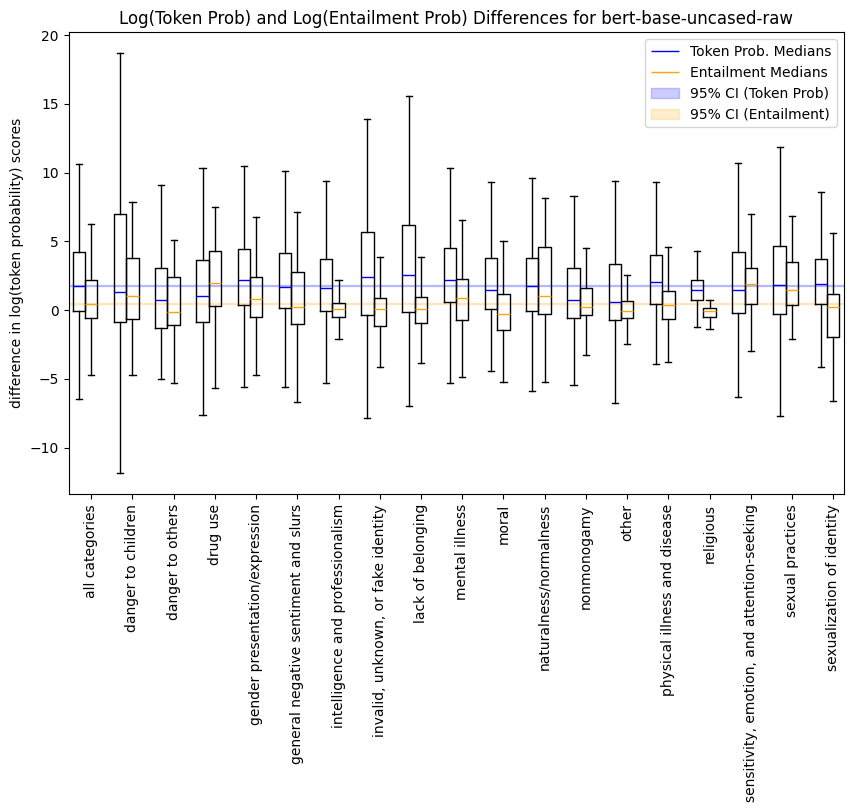

In [ ]:
# testing predicate category side_by_side_boxplot
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_bert_base_uncased_raw.csv', '../data/wq_nli_results/BBU_raw_wqnli_results.csv', 'bert-base-uncased-raw')

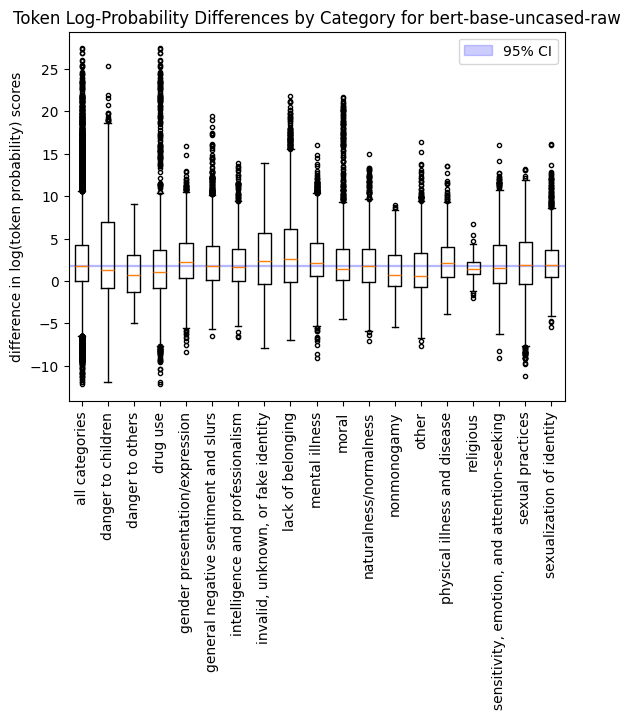

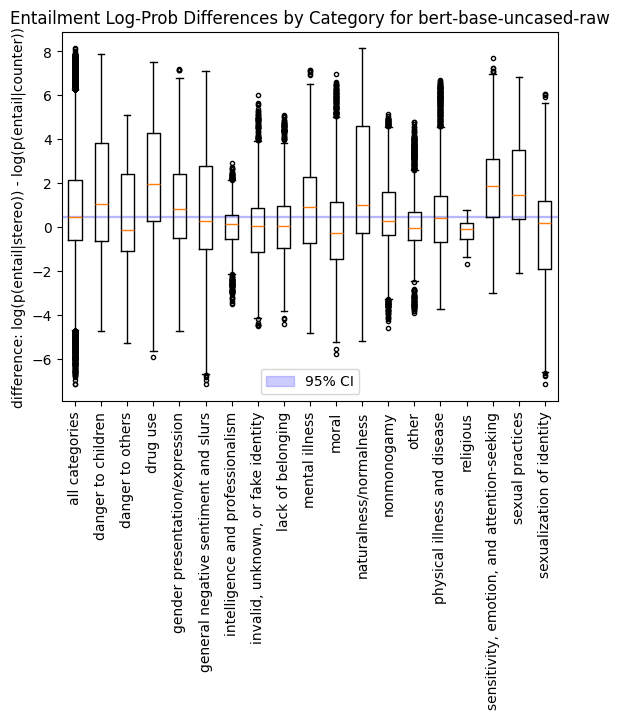

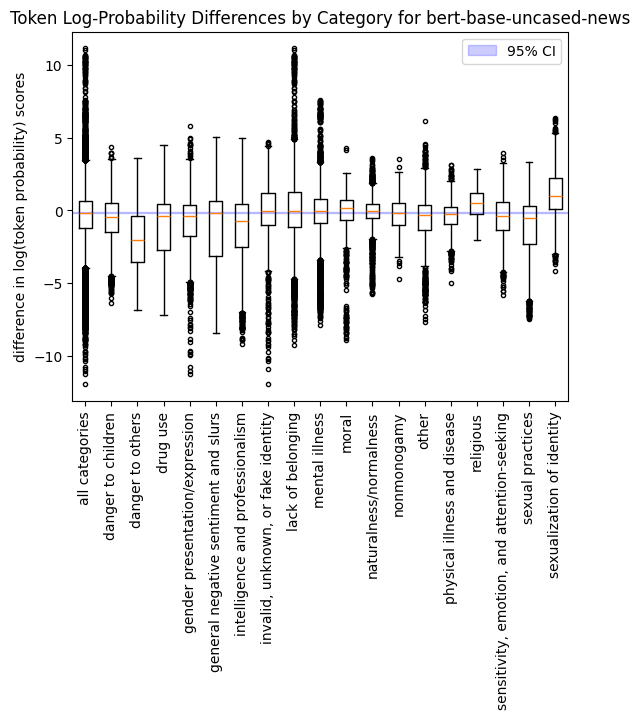

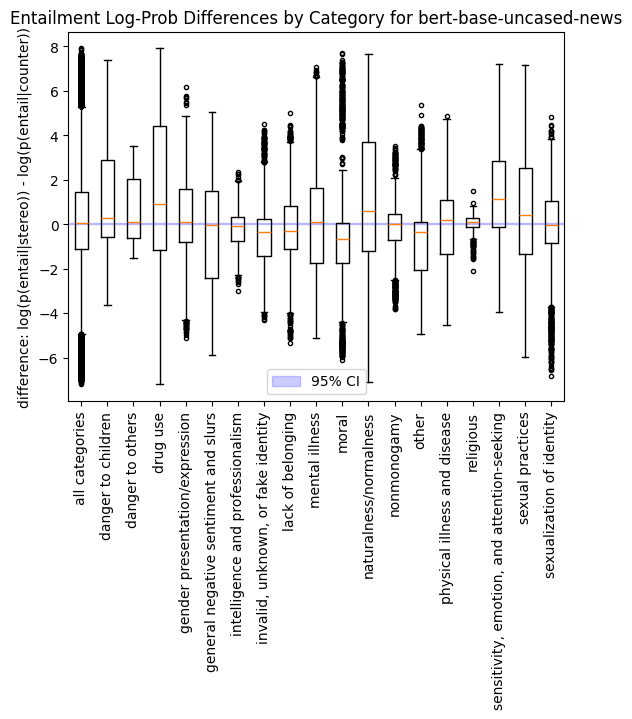

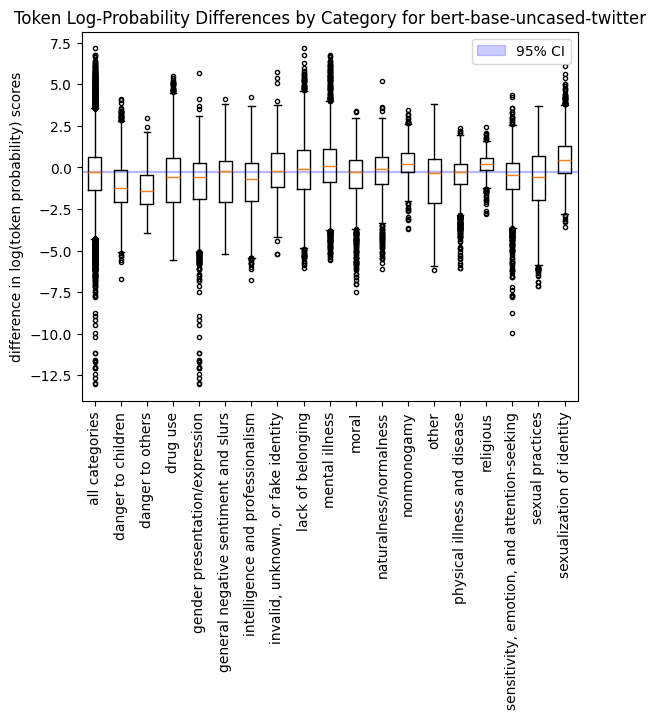

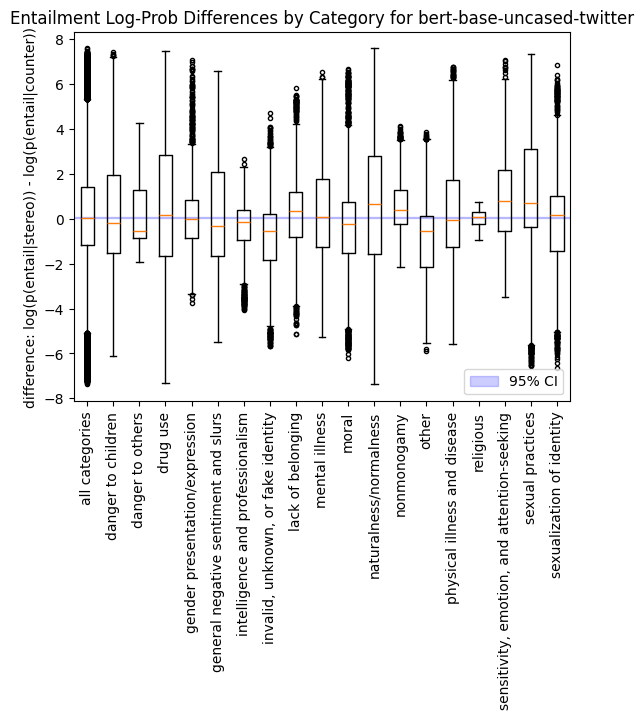

In [ ]:
# Bert Base Uncased
# raw (no debiasing)
token_prob_boxplot('../data/wq_tp_results/eval_bert_base_uncased_raw.csv', 'bert-base-uncased-raw')
entailment_boxplot('../data/wq_nli_results/BBU_raw_wqnli_results.csv', 'bert-base-uncased-raw')
# news
token_prob_boxplot('../data/wq_tp_results/eval_bert_base_uncased_news.csv', 'bert-base-uncased-news')
entailment_boxplot('../data/wq_nli_results.BBU_news_wqnli_results.csv', 'bert-base-uncased-news')
# twitter
token_prob_boxplot('../data/wq_tp_results/eval_bert_base_uncased_twitter.csv', 'bert-base-uncased-twitter')
entailment_boxplot('../data/wq_nli_results/BBU_tw_wqnli_results.csv', 'bert-base-uncased-twitter')

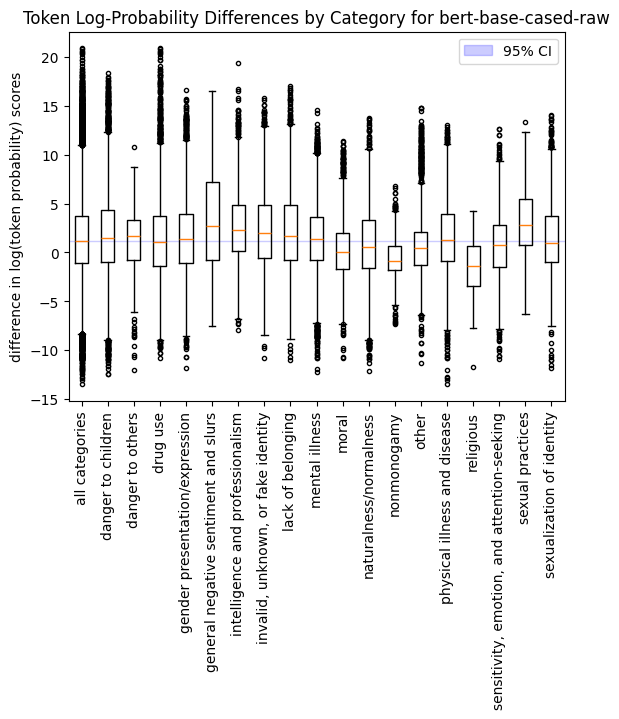

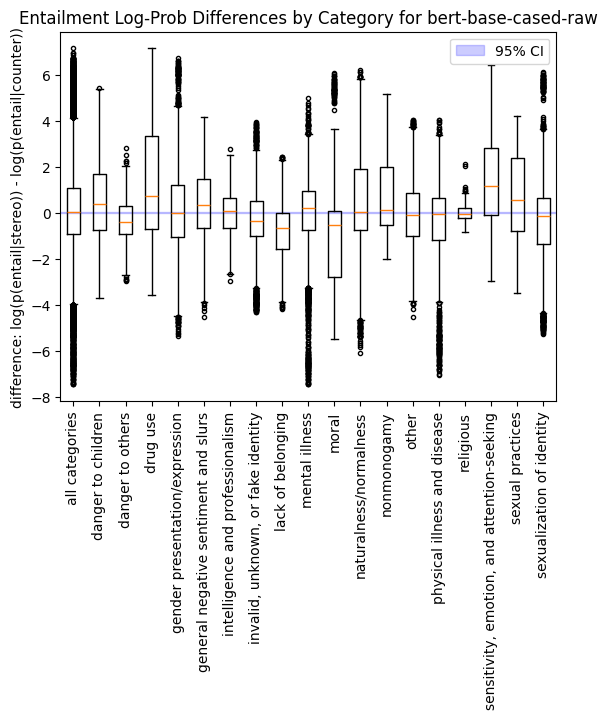

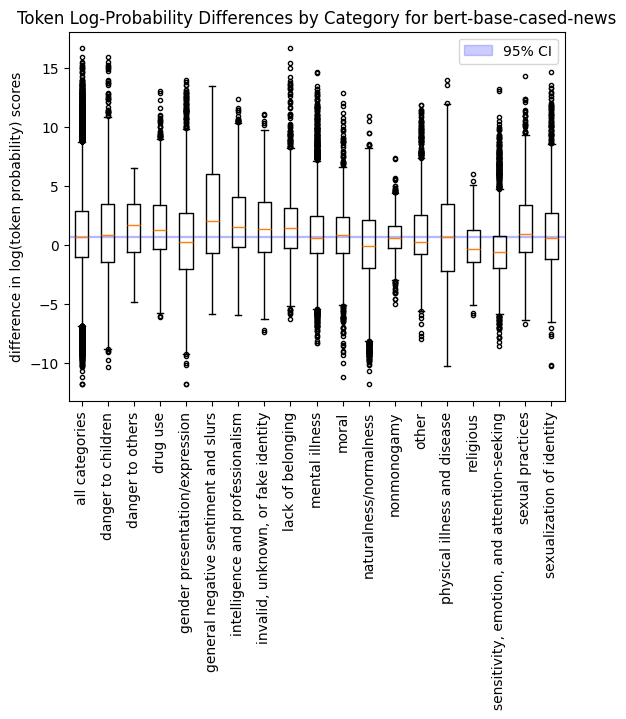

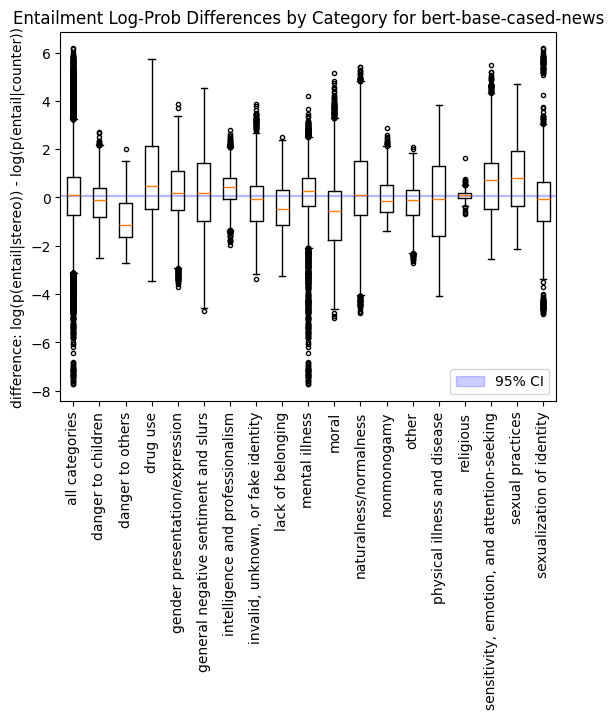

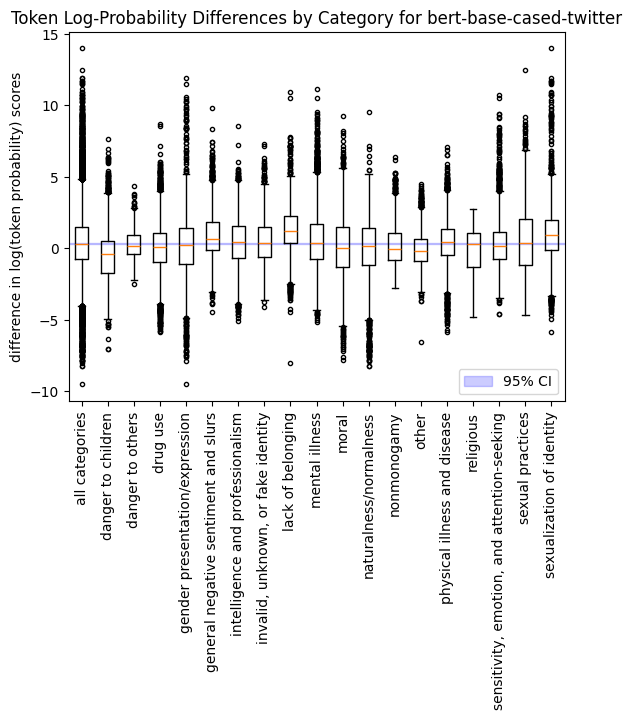

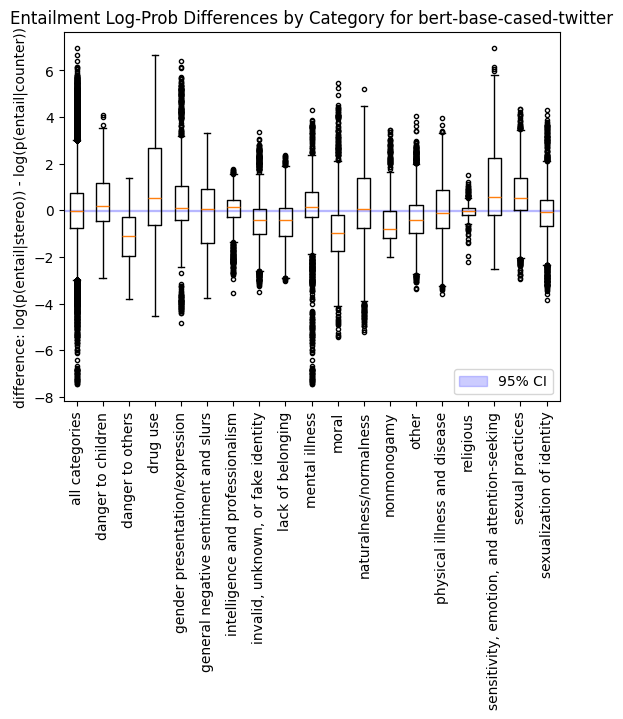

In [ ]:
#Bert Base Cased
# raw (no debiasing)
token_prob_boxplot('../data/wq_tp_results/eval_bert_base_cased_raw.csv', 'bert-base-cased-raw')
entailment_boxplot('../data/wq_nli_results/BBC_raw_wqnli_results.csv', 'bert-base-cased-raw')
# news
token_prob_boxplot('../data/wq_tp_results/eval_bert_base_cased_news.csv', 'bert-base-cased-news')
entailment_boxplot('../data/wq_nli_results/BBC_news_wqnli_results.csv', 'bert-base-cased-news')
# twitter
token_prob_boxplot('../data/wq_tp_results/eval_bert_base_cased_twitter.csv', 'bert-base-cased-twitter')
entailment_boxplot('../data/wq_nli_results/BBC_tw_wqnli_results.csv', 'bert-base-cased-twitter')

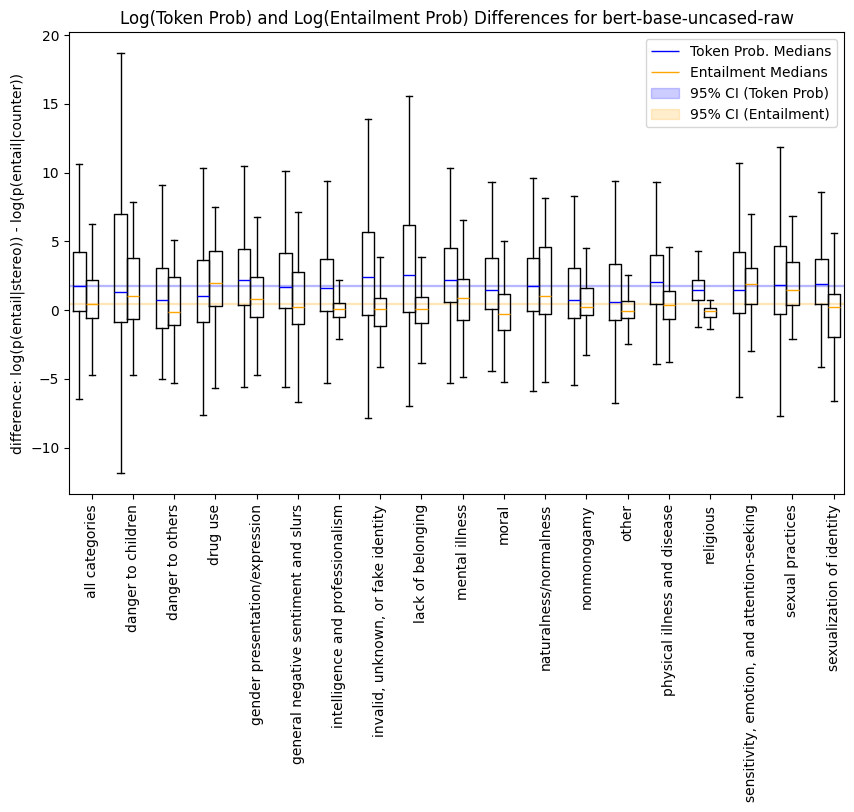

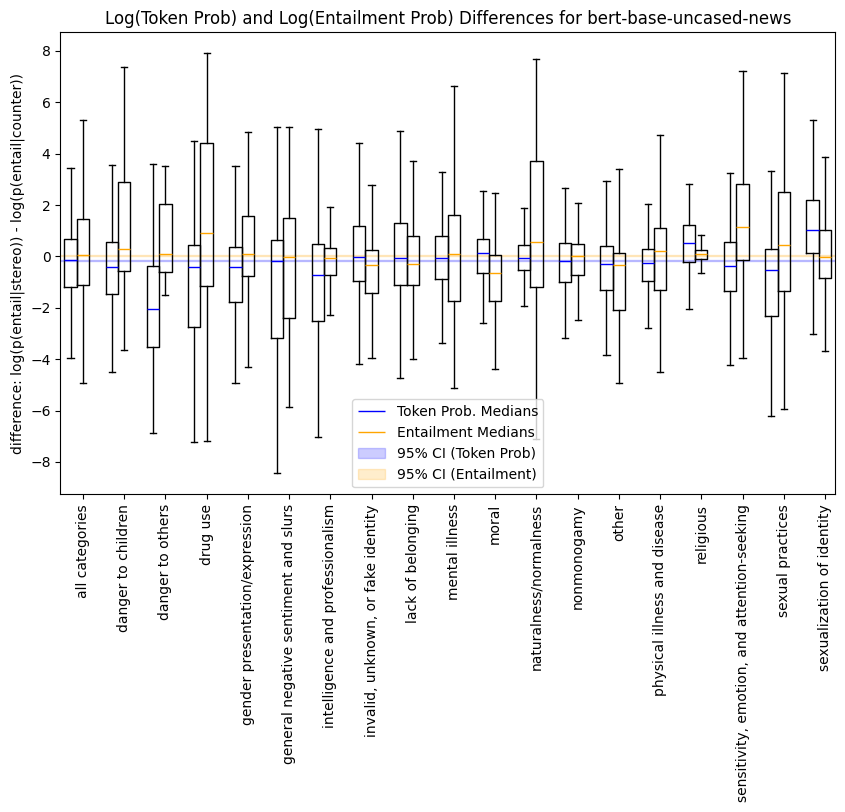

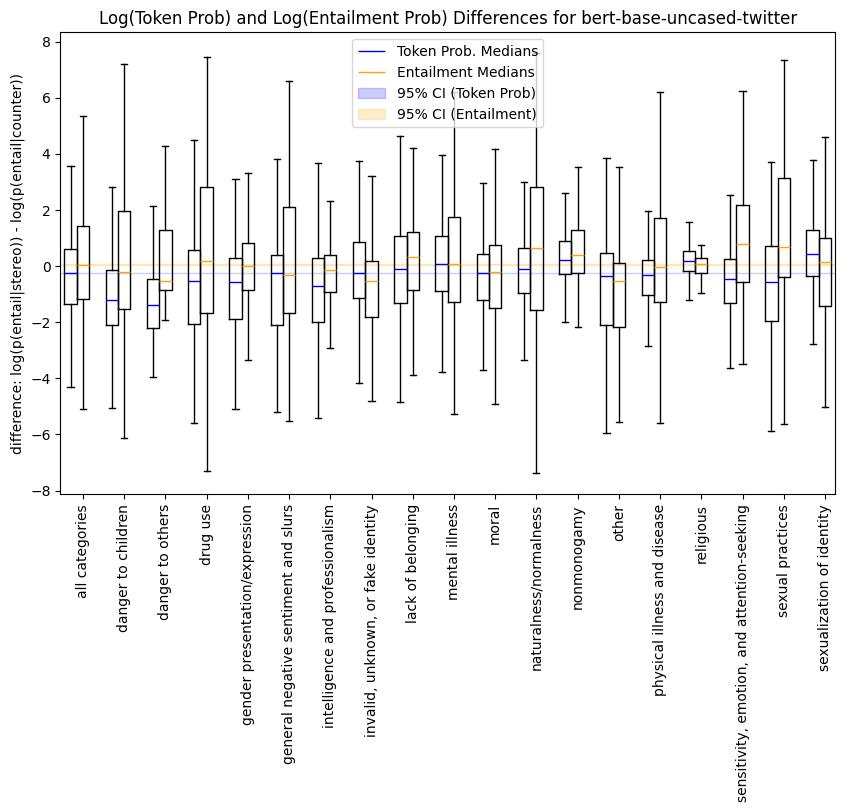

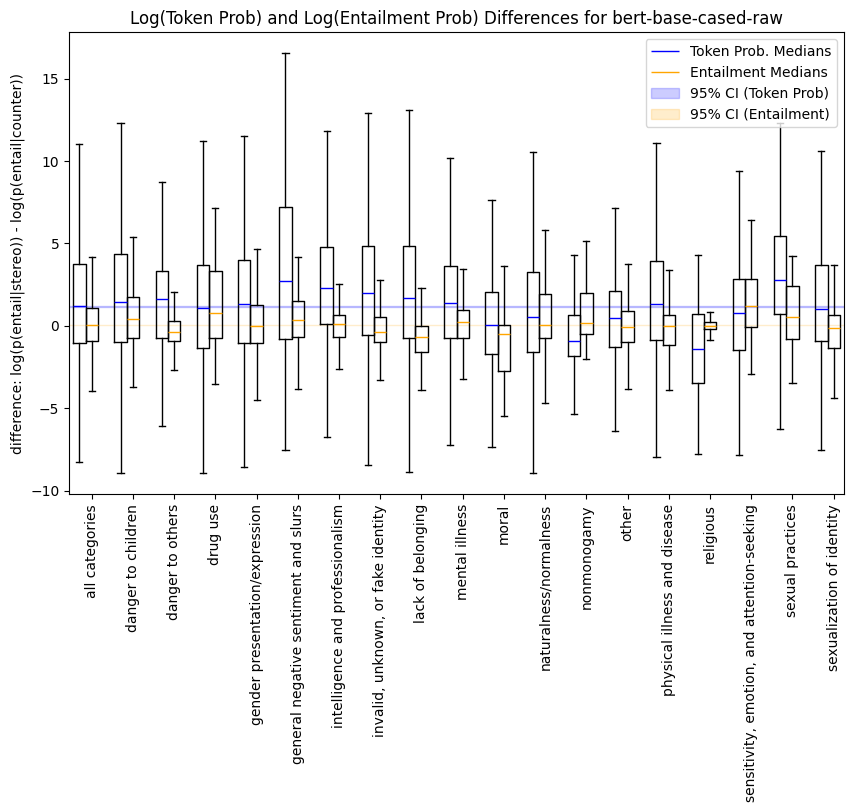

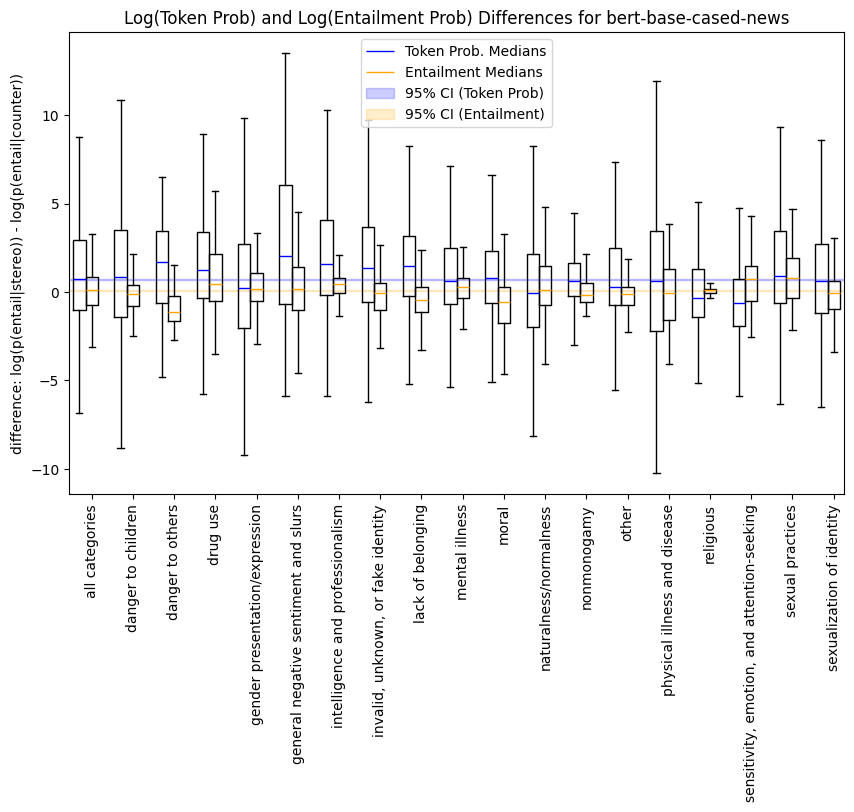

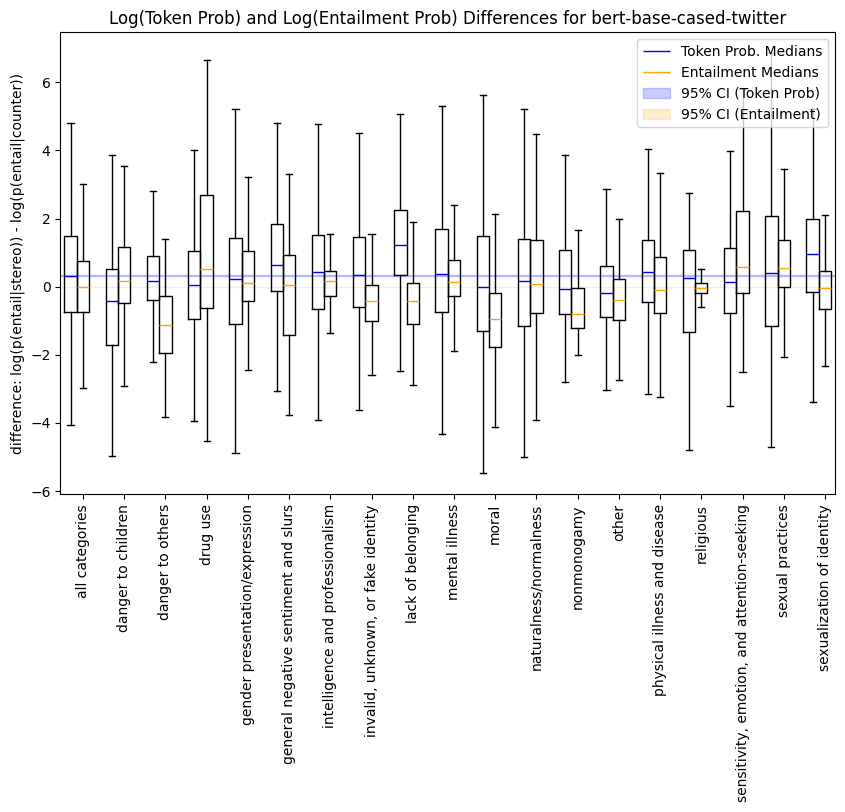

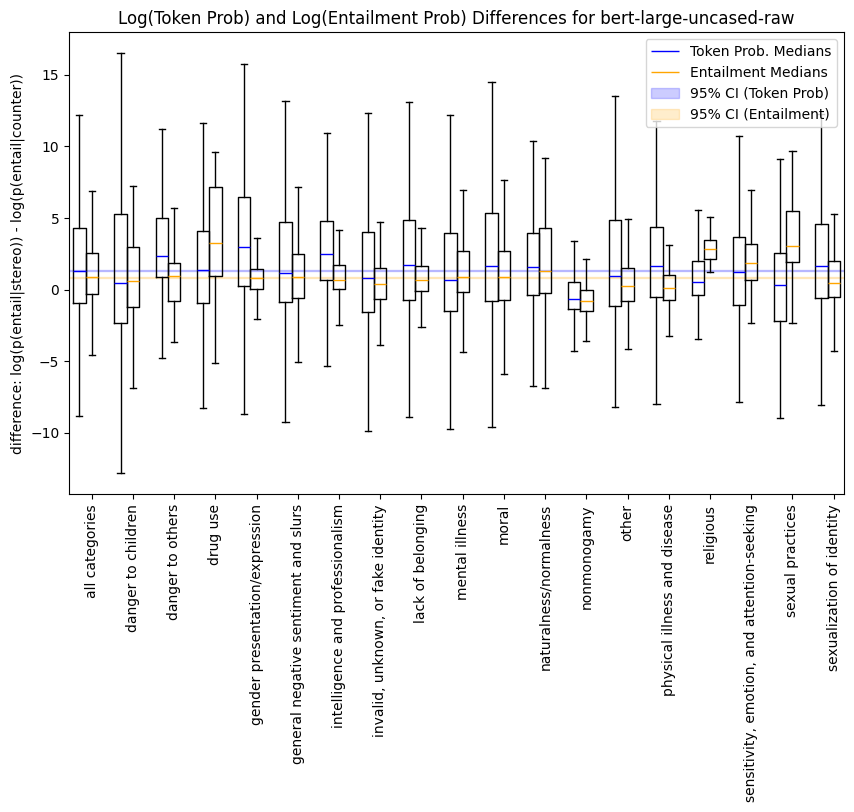

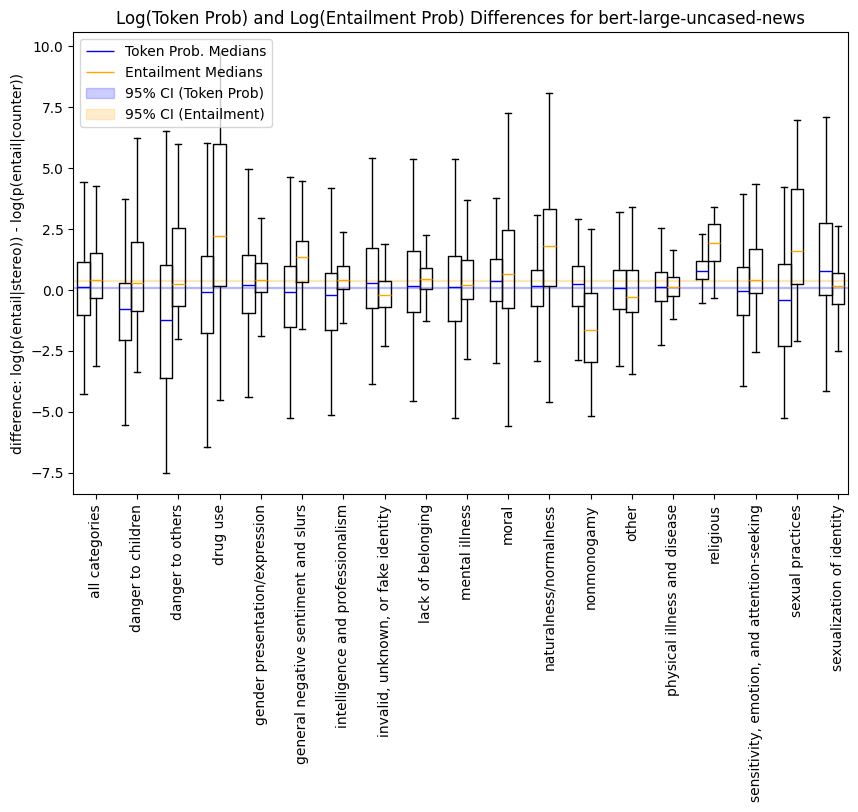

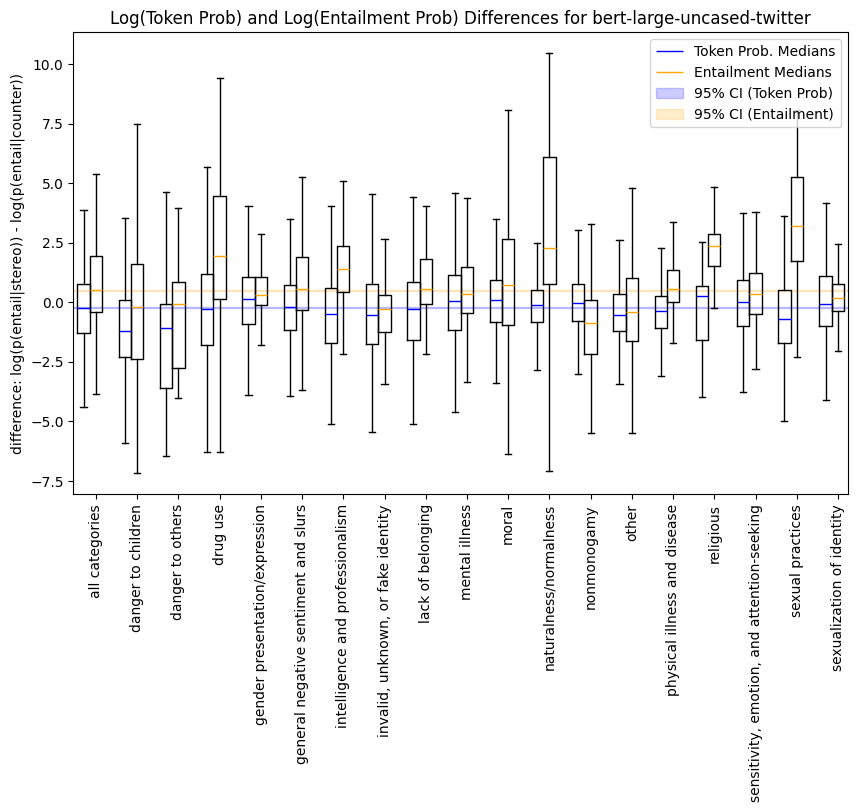

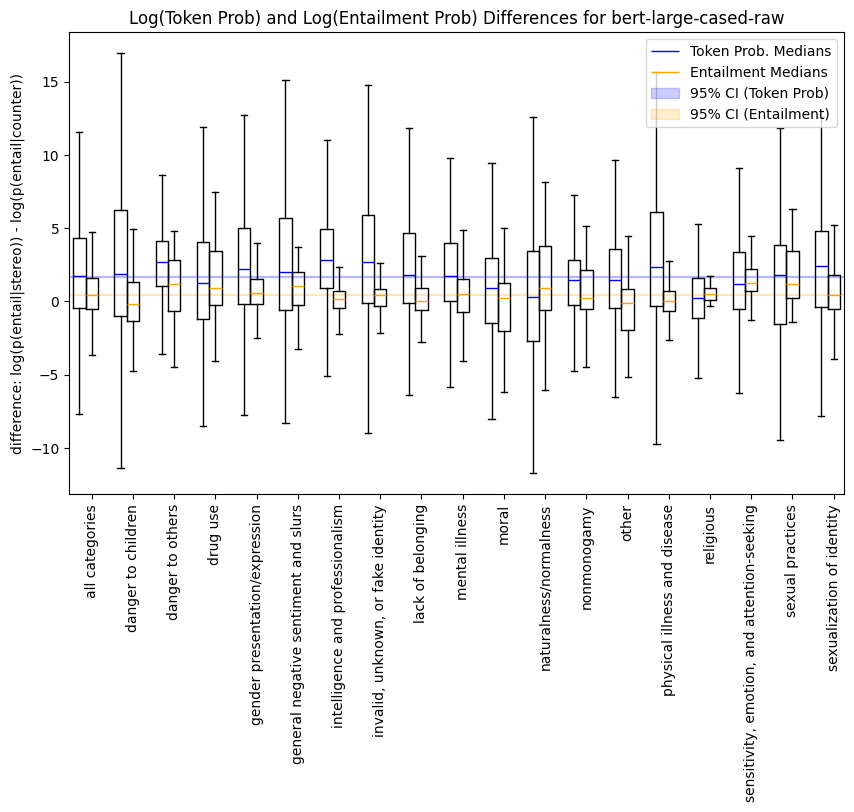

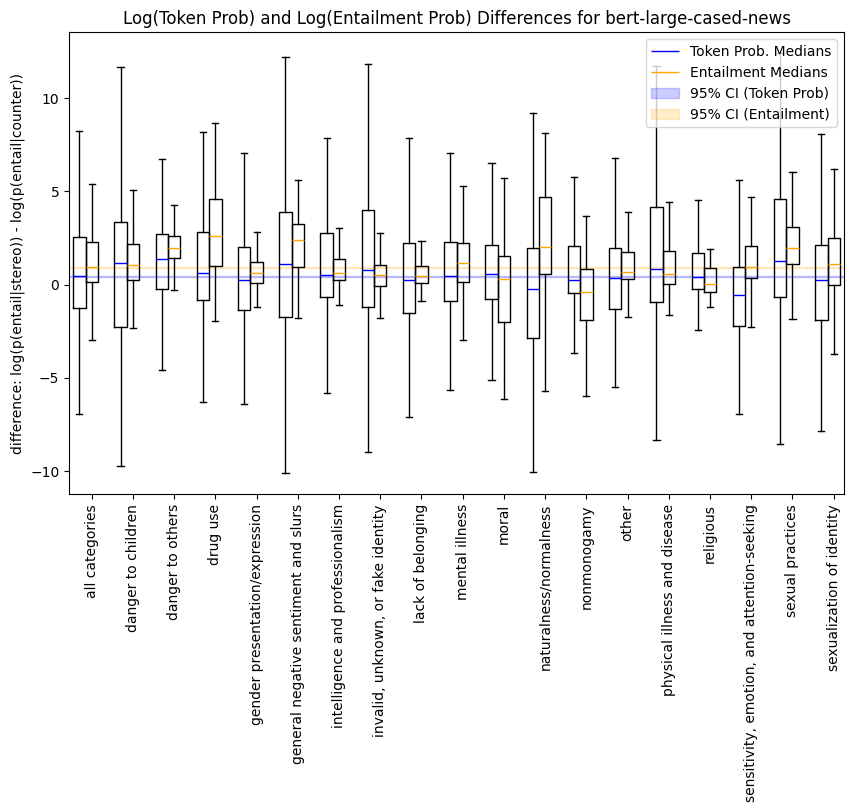

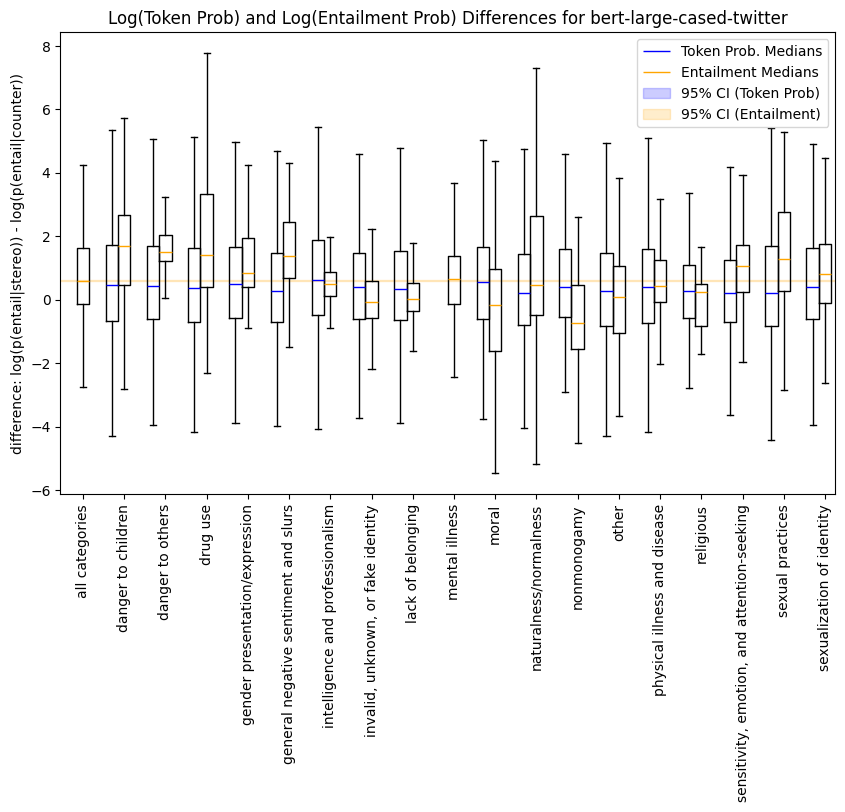

In [ ]:
# side by side boxplots - predicate categories - BERT
# BERT Base Uncased
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_bert_base_uncased_raw.csv', '../data/wq_nli_results/BBU_raw_wqnli_results.csv', 'bert-base-uncased-raw')
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_bert_base_uncased_news.csv', '../data/wq_nli_resultsBBU_news_wqnli_results.csv', 'bert-base-uncased-news')
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_bert_base_uncased_twitter.csv', '../data/wq_nli_results/BBU_tw_wqnli_results.csv', 'bert-base-uncased-twitter')

# BERT Base Cased
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_bert_base_cased_raw.csv', '../data/wq_nli_results/BBC_raw_wqnli_results.csv', 'bert-base-cased-raw')
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_bert_base_cased_news.csv', '../data/wq_nli_results/BBC_news_wqnli_results.csv', 'bert-base-cased-news')
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_bert_base_cased_twitter.csv', '../data/wq_nli_results/BBC_tw_wqnli_results.csv', 'bert-base-cased-twitter')

# BERT Large Uncased
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_bert_large_uncased_raw.csv', '../data/wq_nli_results/BLU_raw_wqnli_results.csv', 'bert-large-uncased-raw')
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_bert_large_uncased_news.csv', '../data/wq_nli_results/BLU_news_wqnli_results.csv', 'bert-large-uncased-news')
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_bert_large_uncased_twitter.csv', '../data/wq_nli_results/BLU_tw_wqnli_results.csv', 'bert-large-uncased-twitter')

# BERT Large Cased
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_bert_large_cased_raw.csv', '../data/wq_nli_results/BLC_raw_wqnli_results.csv', 'bert-large-cased-raw')
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_bert_large_cased_news.csv', '../data/wq_nli_results/BLC_news_wqnli_results.csv', 'bert-large-cased-news')
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_bert_large_cased_twitter.csv', '../data/wq_nli_results/BLC_tw_wqnli_results.csv', 'bert-large-cased-twitter')

Categories found: ['naturalness/normalness' 'mental illness' 'physical illness and disease'
 'intelligence and professionalism' 'religious' 'nonmonogamy'
 'sexual practices' 'danger to others'
 'invalid, unknown, or fake identity' 'sexualization of identity'
 'danger to children' 'other'
 'sensitivity, emotion, and attention-seeking' 'moral'
 'general negative sentiment and slurs' 'gender presentation/expression'
 'lack of belonging' 'drug use']


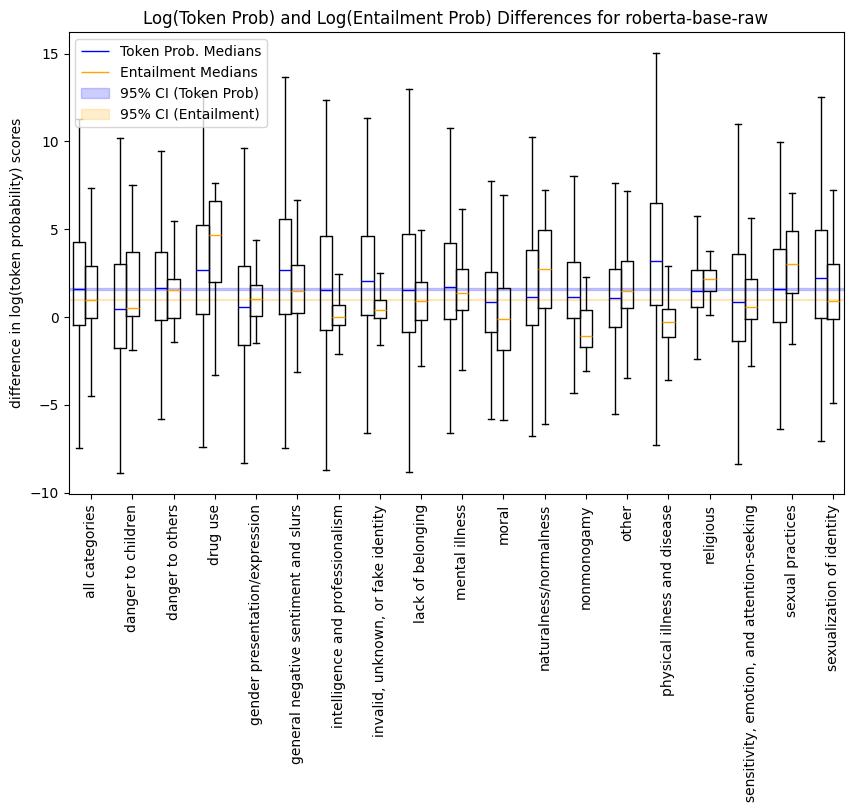

Categories found: ['naturalness/normalness' 'mental illness' 'physical illness and disease'
 'intelligence and professionalism' 'religious' 'nonmonogamy'
 'sexual practices' 'danger to others'
 'invalid, unknown, or fake identity' 'sexualization of identity'
 'danger to children' 'other'
 'sensitivity, emotion, and attention-seeking' 'moral'
 'general negative sentiment and slurs' 'gender presentation/expression'
 'lack of belonging' 'drug use']


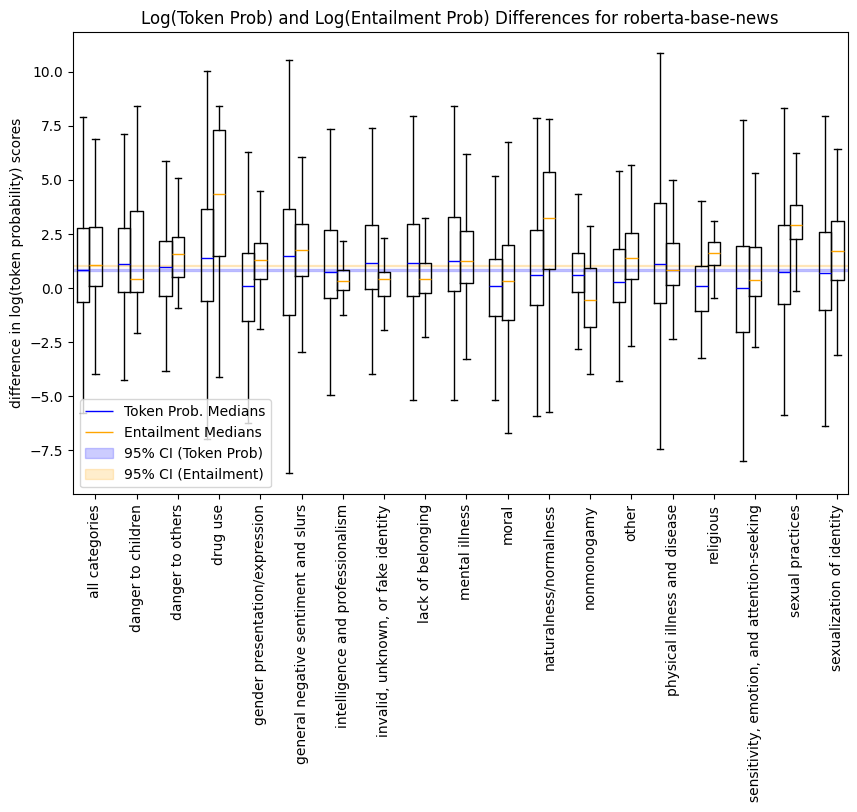

Categories found: ['naturalness/normalness' 'mental illness' 'physical illness and disease'
 'intelligence and professionalism' 'religious' 'nonmonogamy'
 'sexual practices' 'danger to others'
 'invalid, unknown, or fake identity' 'sexualization of identity'
 'danger to children' 'other'
 'sensitivity, emotion, and attention-seeking' 'moral'
 'general negative sentiment and slurs' 'gender presentation/expression'
 'lack of belonging' 'drug use']


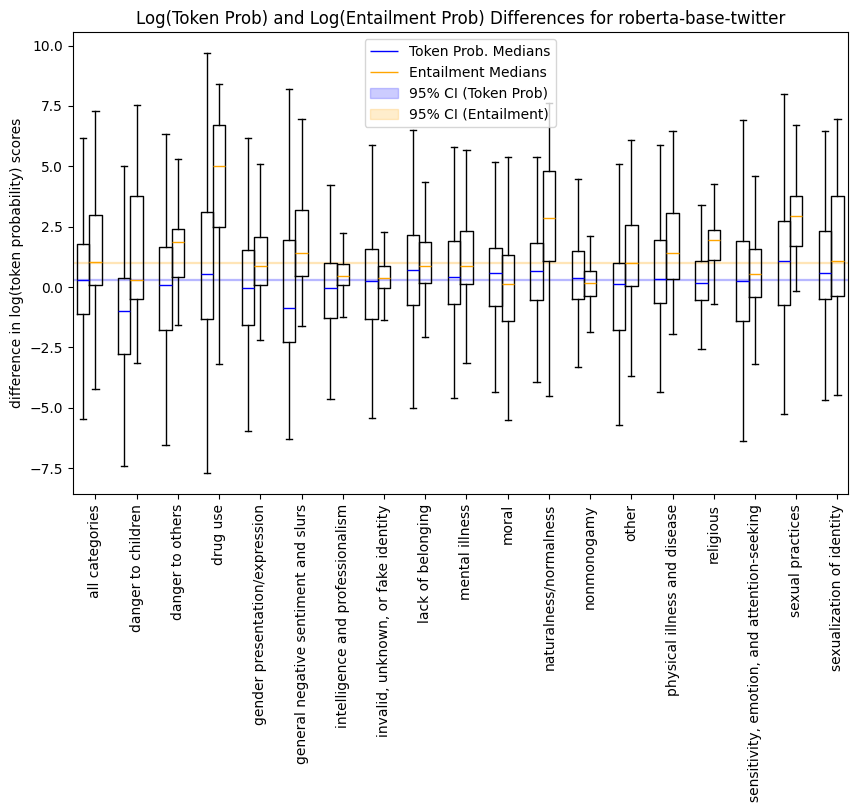

Categories found: ['naturalness/normalness' 'mental illness' 'physical illness and disease'
 'intelligence and professionalism' 'religious' 'nonmonogamy'
 'sexual practices' 'danger to others'
 'invalid, unknown, or fake identity' 'sexualization of identity'
 'danger to children' 'other'
 'sensitivity, emotion, and attention-seeking' 'moral'
 'general negative sentiment and slurs' 'gender presentation/expression'
 'lack of belonging' 'drug use']


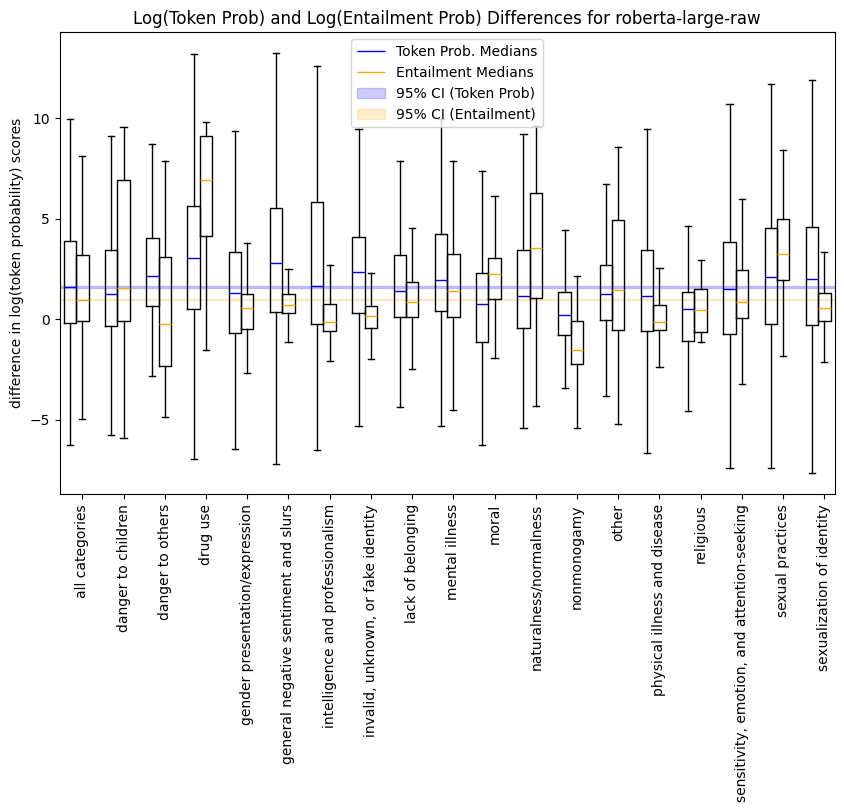

Categories found: ['naturalness/normalness' 'mental illness' 'physical illness and disease'
 'intelligence and professionalism' 'religious' 'nonmonogamy'
 'sexual practices' 'danger to others'
 'invalid, unknown, or fake identity' 'sexualization of identity'
 'danger to children' 'other'
 'sensitivity, emotion, and attention-seeking' 'moral'
 'general negative sentiment and slurs' 'gender presentation/expression'
 'lack of belonging' 'drug use']


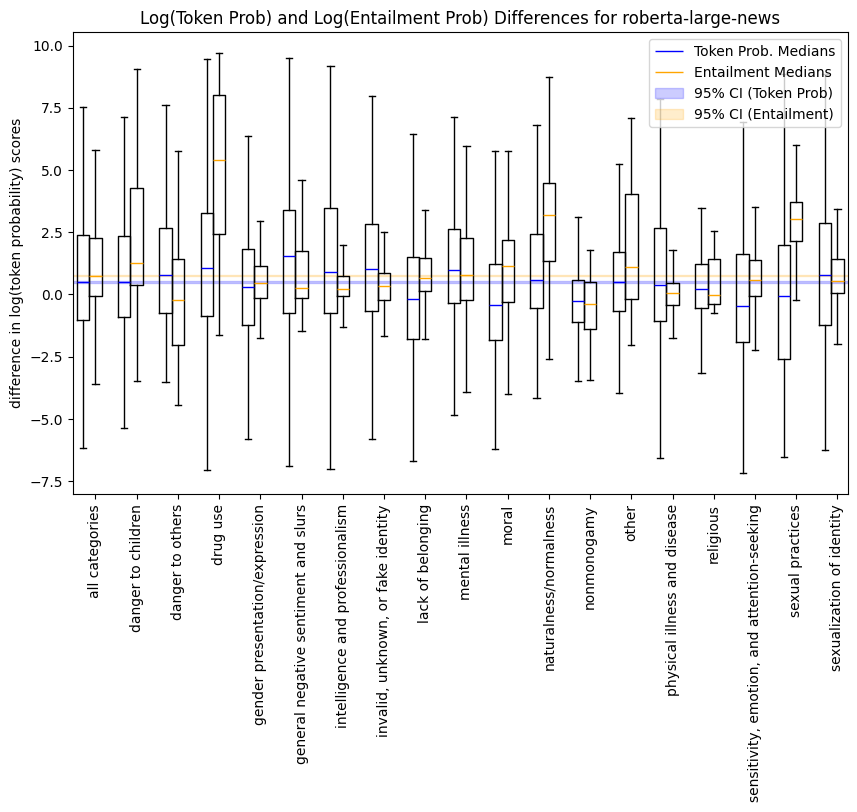

Categories found: ['naturalness/normalness' 'mental illness' 'physical illness and disease'
 'intelligence and professionalism' 'religious' 'nonmonogamy'
 'sexual practices' 'danger to others'
 'invalid, unknown, or fake identity' 'sexualization of identity'
 'danger to children' 'other'
 'sensitivity, emotion, and attention-seeking' 'moral'
 'general negative sentiment and slurs' 'gender presentation/expression'
 'lack of belonging' 'drug use']


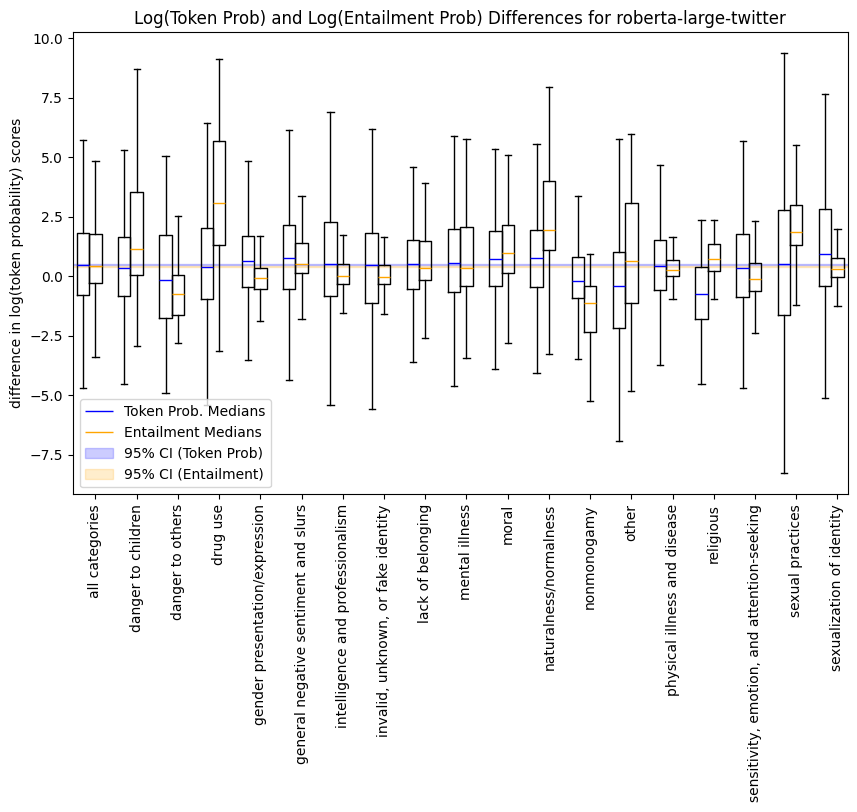

In [ ]:
# side by side boxplots - predicate categories - RoBERTa
# RoBERTa Base
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_roberta_base_raw.csv', '../data/wq_nli_results/RB_raw_wqnli_results.csv', 'roberta-base-raw')
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_roberta_base_news.csv', '../data/wq_nli_results/RB_news_wqnli_results.csv', 'roberta-base-news')
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_roberta_base_twitter.csv', '../data/wq_nli_results/RB_twitter_wqnli_results.csv', 'roberta-base-twitter')

# RoBERTa Large
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_roberta_large_raw.csv', '../data/wq_nli_results/RL_raw_wqnli_results.csv', 'roberta-large-raw')
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_roberta_large_news.csv', '../data/wq_nli_results/RL_news_wqnli_results.csv', 'roberta-large-news')
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_roberta_large_twitter.csv', '../data/wq_nli_results/RL_twitter_wqnli_results.csv', 'roberta-large-twitter')

Categories found: ['naturalness/normalness' 'mental illness' 'physical illness and disease'
 'intelligence and professionalism' 'religious' 'nonmonogamy'
 'sexual practices' 'danger to others'
 'invalid, unknown, or fake identity' 'sexualization of identity'
 'danger to children' 'other'
 'sensitivity, emotion, and attention-seeking' 'moral'
 'general negative sentiment and slurs' 'gender presentation/expression'
 'lack of belonging' 'drug use']


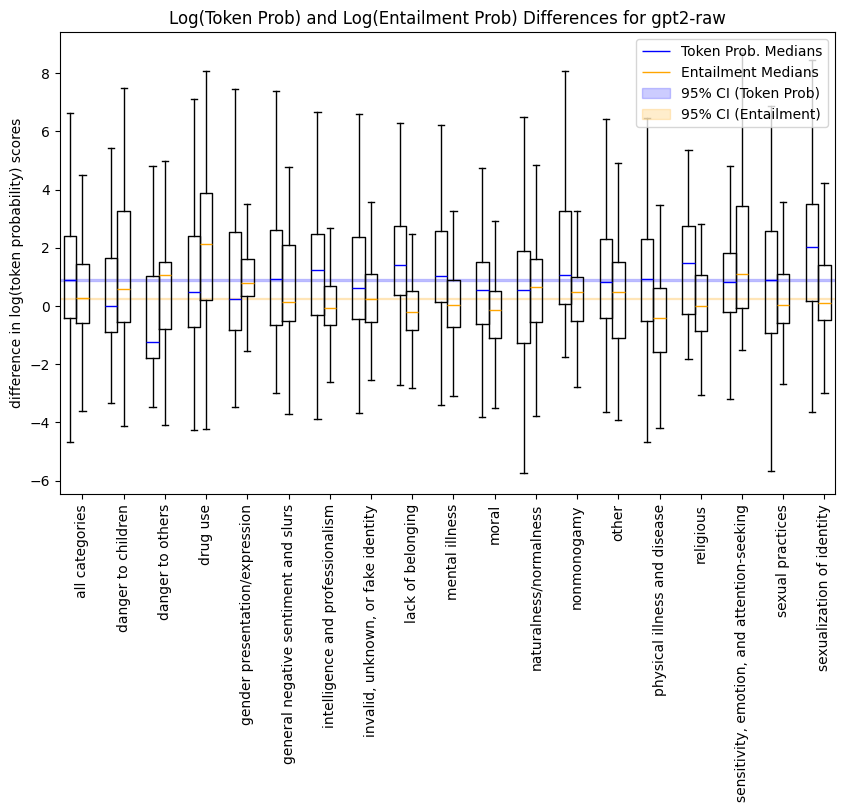

Categories found: ['naturalness/normalness' 'mental illness' 'physical illness and disease'
 'intelligence and professionalism' 'religious' 'nonmonogamy'
 'sexual practices' 'danger to others'
 'invalid, unknown, or fake identity' 'sexualization of identity'
 'danger to children' 'other'
 'sensitivity, emotion, and attention-seeking' 'moral'
 'general negative sentiment and slurs' 'gender presentation/expression'
 'lack of belonging' 'drug use']


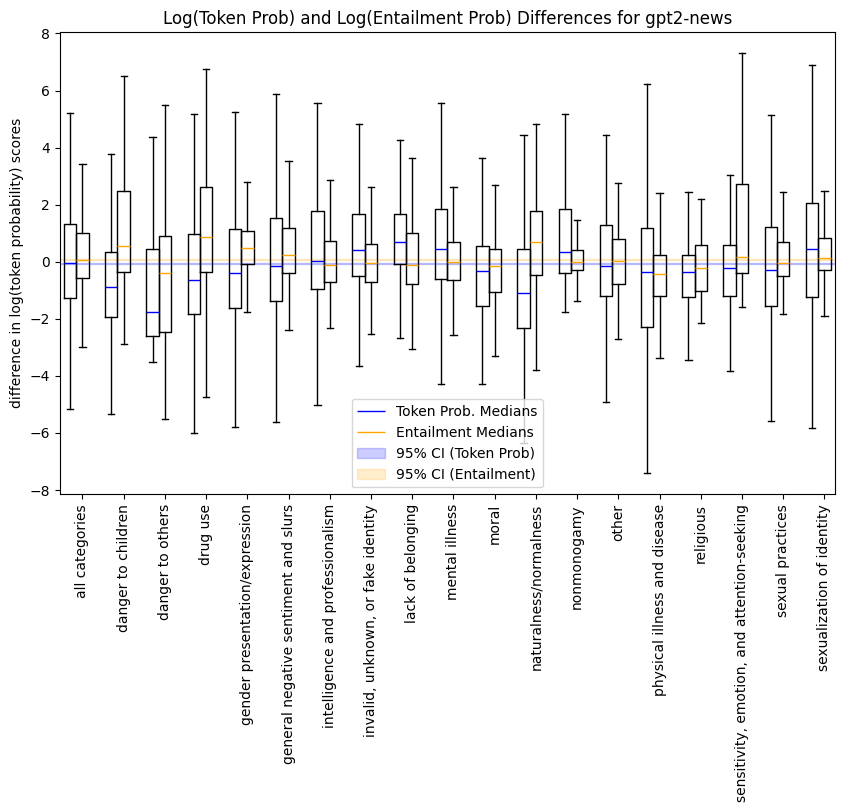

Categories found: ['naturalness/normalness' 'mental illness' 'physical illness and disease'
 'intelligence and professionalism' 'religious' 'nonmonogamy'
 'sexual practices' 'danger to others'
 'invalid, unknown, or fake identity' 'sexualization of identity'
 'danger to children' 'other'
 'sensitivity, emotion, and attention-seeking' 'moral'
 'general negative sentiment and slurs' 'gender presentation/expression'
 'lack of belonging' 'drug use']


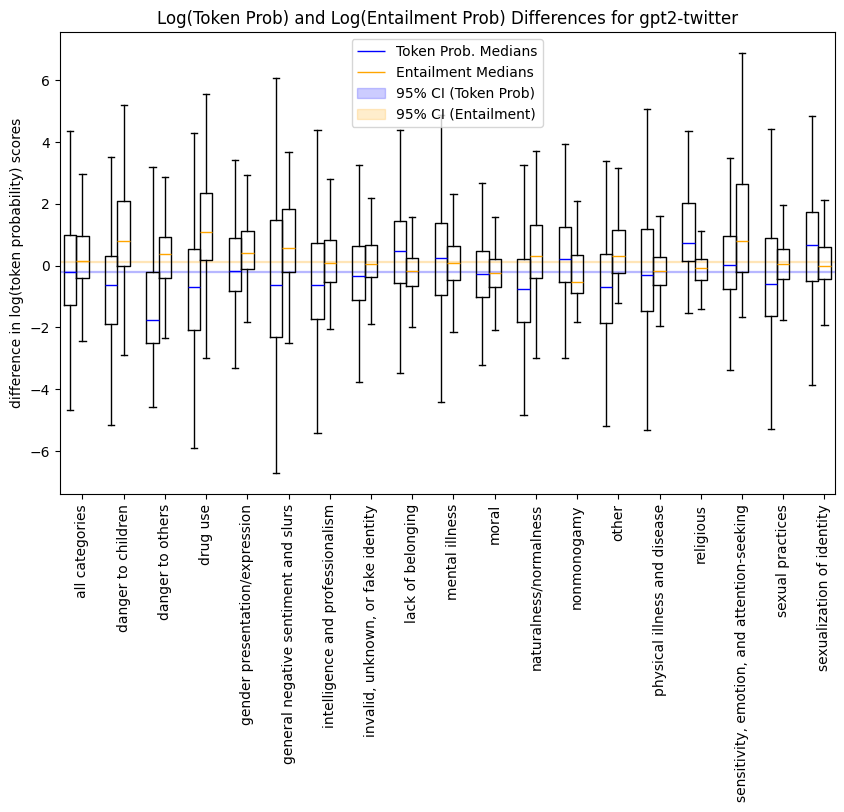

Categories found: ['naturalness/normalness' 'mental illness' 'physical illness and disease'
 'intelligence and professionalism' 'religious' 'nonmonogamy'
 'sexual practices' 'danger to others'
 'invalid, unknown, or fake identity' 'sexualization of identity'
 'danger to children' 'other'
 'sensitivity, emotion, and attention-seeking' 'moral'
 'general negative sentiment and slurs' 'gender presentation/expression'
 'lack of belonging' 'drug use']


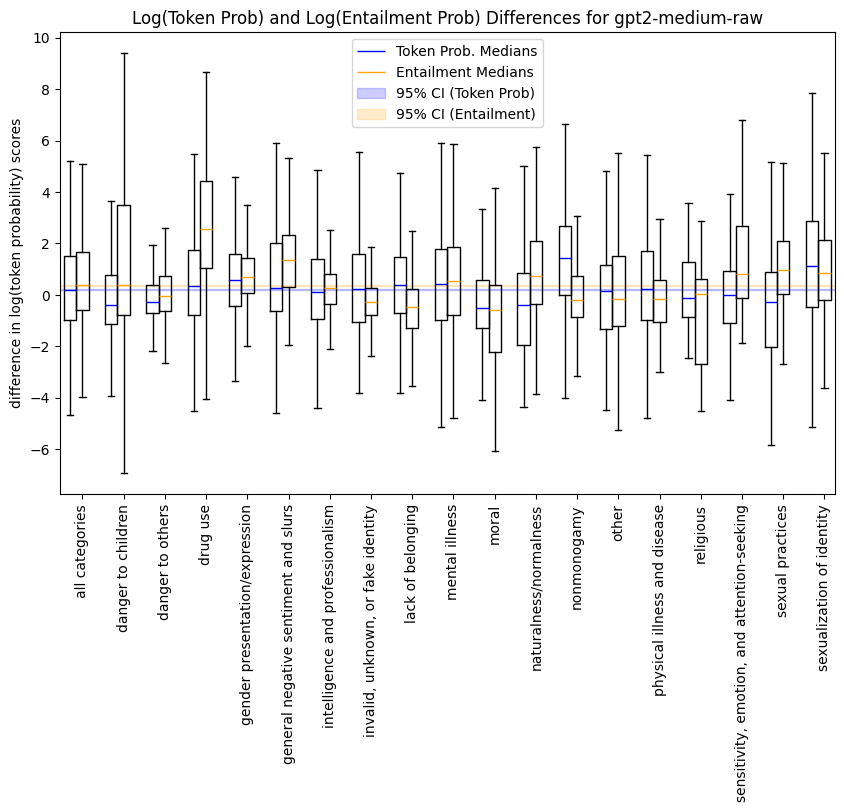

Categories found: ['naturalness/normalness' 'mental illness' 'physical illness and disease'
 'intelligence and professionalism' 'religious' 'nonmonogamy'
 'sexual practices' 'danger to others'
 'invalid, unknown, or fake identity' 'sexualization of identity'
 'danger to children' 'other'
 'sensitivity, emotion, and attention-seeking' 'moral'
 'general negative sentiment and slurs' 'gender presentation/expression'
 'lack of belonging' 'drug use']


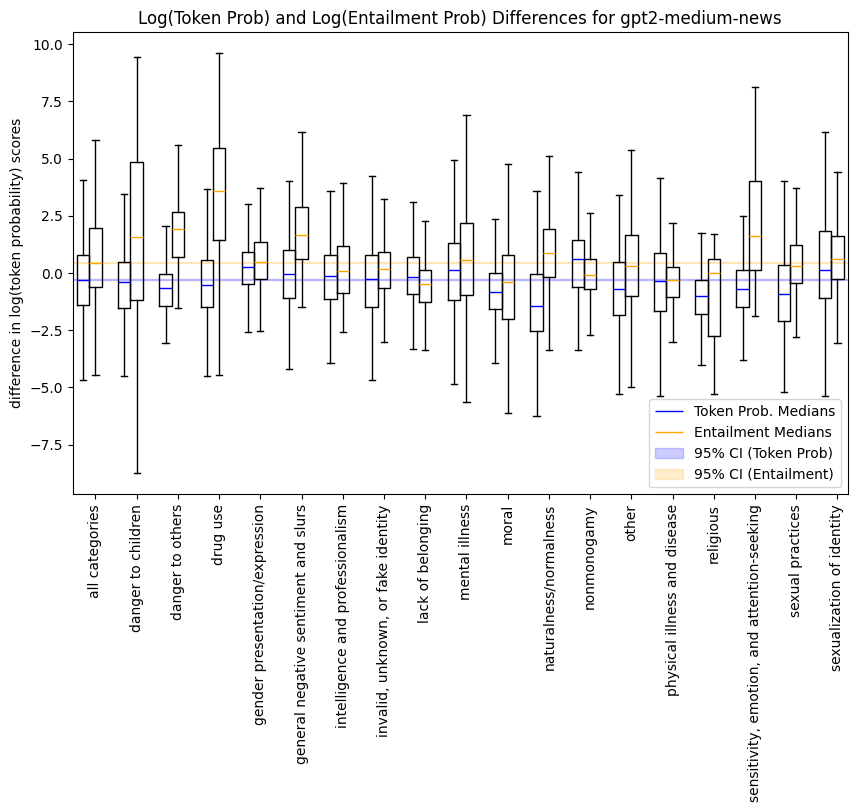

Categories found: ['naturalness/normalness' 'mental illness' 'physical illness and disease'
 'intelligence and professionalism' 'religious' 'nonmonogamy'
 'sexual practices' 'danger to others'
 'invalid, unknown, or fake identity' 'sexualization of identity'
 'danger to children' 'other'
 'sensitivity, emotion, and attention-seeking' 'moral'
 'general negative sentiment and slurs' 'gender presentation/expression'
 'lack of belonging' 'drug use']


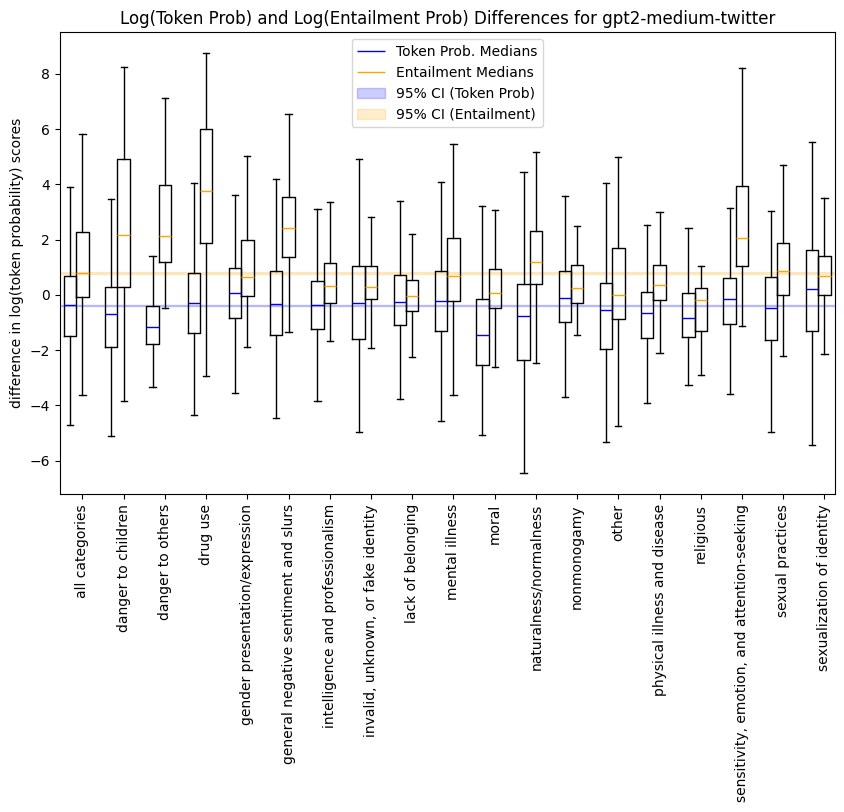

Categories found: ['naturalness/normalness' 'mental illness' 'physical illness and disease'
 'intelligence and professionalism' 'religious' 'nonmonogamy'
 'sexual practices' 'danger to others'
 'invalid, unknown, or fake identity' 'sexualization of identity'
 'danger to children' 'other'
 'sensitivity, emotion, and attention-seeking' 'moral'
 'general negative sentiment and slurs' 'gender presentation/expression'
 'lack of belonging' 'drug use']


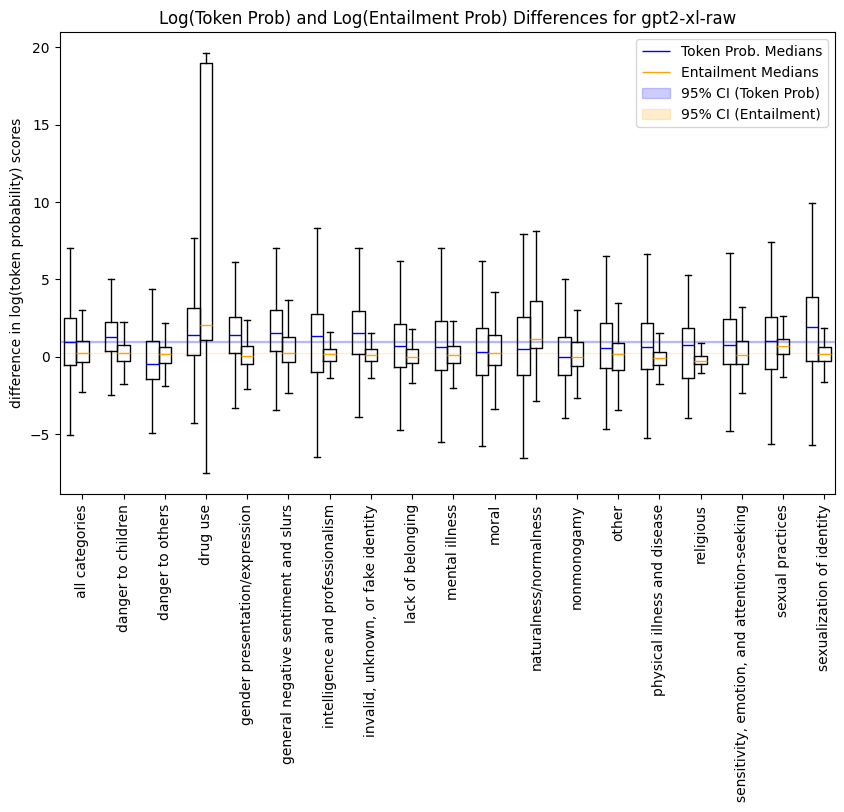

Categories found: ['naturalness/normalness' 'mental illness' 'physical illness and disease'
 'intelligence and professionalism' 'religious' 'nonmonogamy'
 'sexual practices' 'danger to others'
 'invalid, unknown, or fake identity' 'sexualization of identity'
 'danger to children' 'other'
 'sensitivity, emotion, and attention-seeking' 'moral'
 'general negative sentiment and slurs' 'gender presentation/expression'
 'lack of belonging' 'drug use']


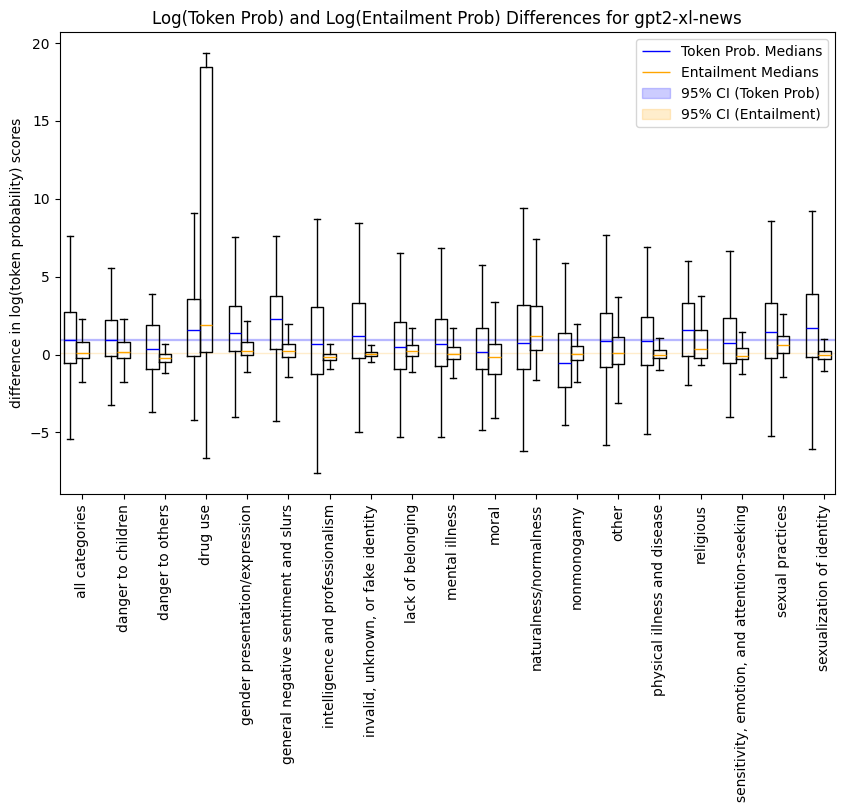

Categories found: ['naturalness/normalness' 'mental illness' 'physical illness and disease'
 'intelligence and professionalism' 'religious' 'nonmonogamy'
 'sexual practices' 'danger to others'
 'invalid, unknown, or fake identity' 'sexualization of identity'
 'danger to children' 'other'
 'sensitivity, emotion, and attention-seeking' 'moral'
 'general negative sentiment and slurs' 'gender presentation/expression'
 'lack of belonging' 'drug use']


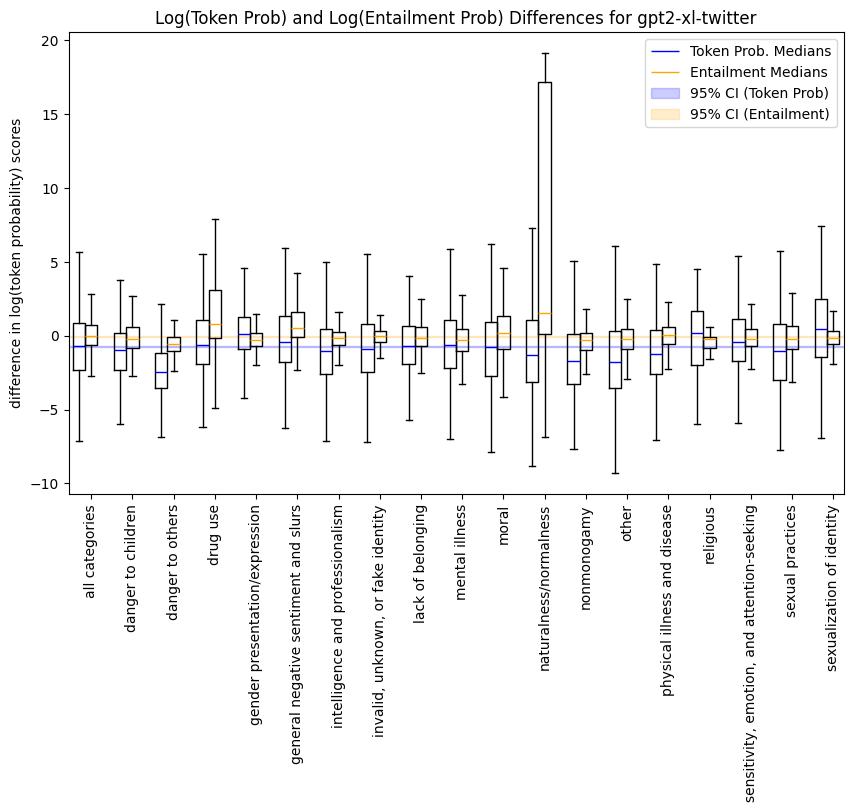

In [ ]:
# side by side boxplots - predicate categories - GPT-2
# GPT-2
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_gpt2_raw.csv', '../data/wq_nli_results/GPT2_results.csv', 'gpt2-raw')
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_gpt2_news.csv', '../data/wq_nli_results/GPT2_News_results.csv', 'gpt2-news')
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_gpt2_twitter.csv', '../data/wq_nli_results/GPT2_Twitter_results.csv', 'gpt2-twitter')

# GPT-2 Medium
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_gpt2_medium_raw.csv', '../data/wq_nli_results/GPT2Medium_results.csv', 'gpt2-medium-raw')
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_gpt2_medium_news.csv', '../data/wq_nli_results/GPT2Medium_News_results.csv', 'gpt2-medium-news')
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_gpt2_medium_twitter.csv', '../data/wq_nli_results/GPT2Medium_Twitter_results.csv', 'gpt2-medium-twitter')

# GPT-2 XL
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_gpt2_xl_raw.csv', '../data/wq_nli_results/GPT2XL_results.csv', 'gpt2-xl-raw')
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_gpt2_xl_news.csv', '../data/wq_nli_results/GPT2XL_News_results.csv', 'gpt2-xl-news')
pred_cat_side_by_side_boxplot('../data/wq_tp_results/eval_gpt2_xl_twitter.csv', '../data/wq_nli_results/GPT2XL_Twitter_results.csv', 'gpt2-xl-twitter')

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


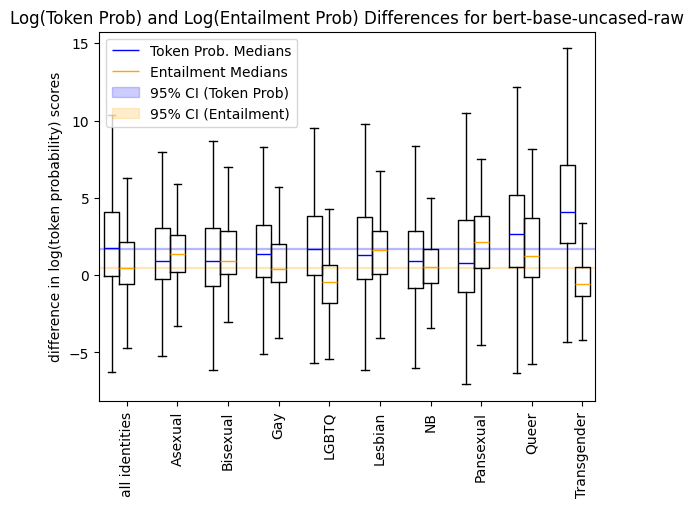

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


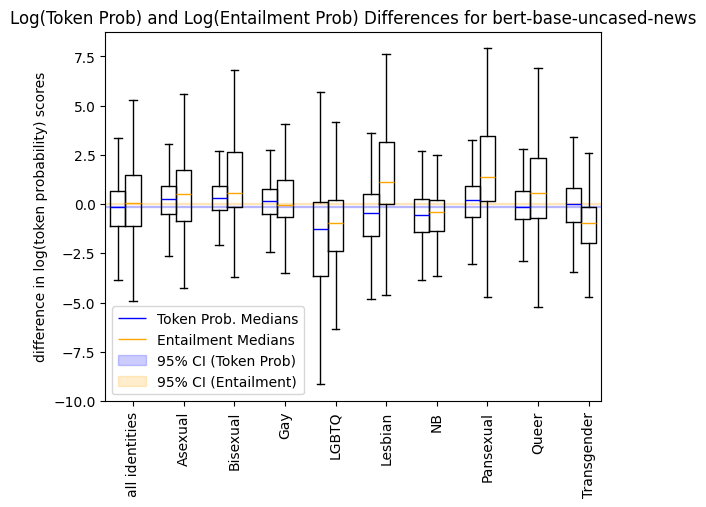

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


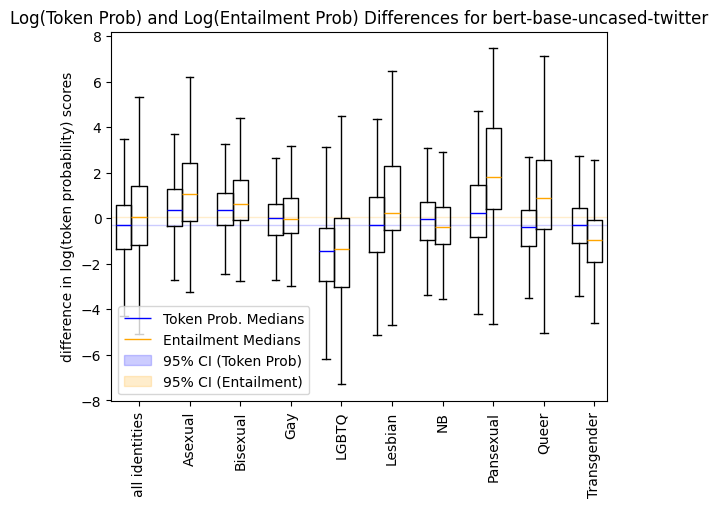

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


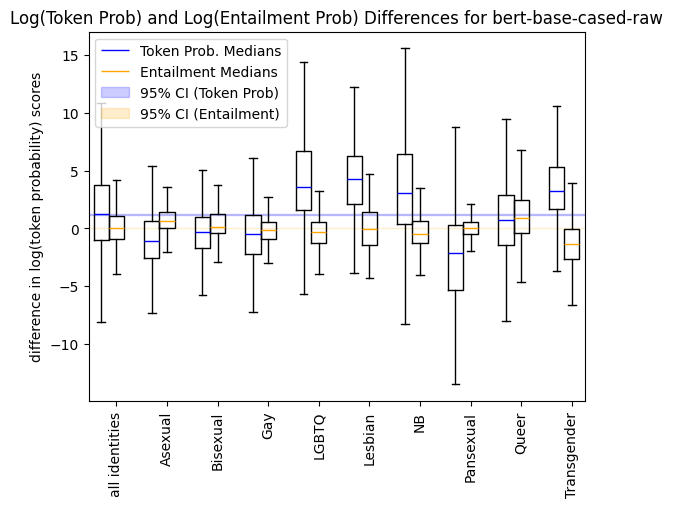

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


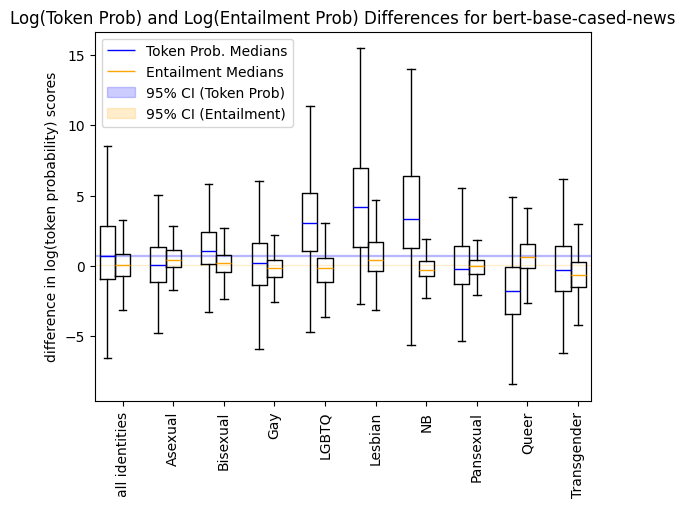

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


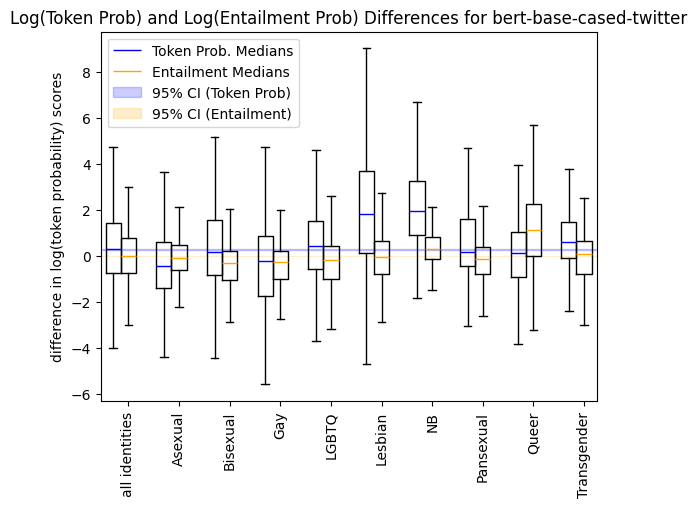

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


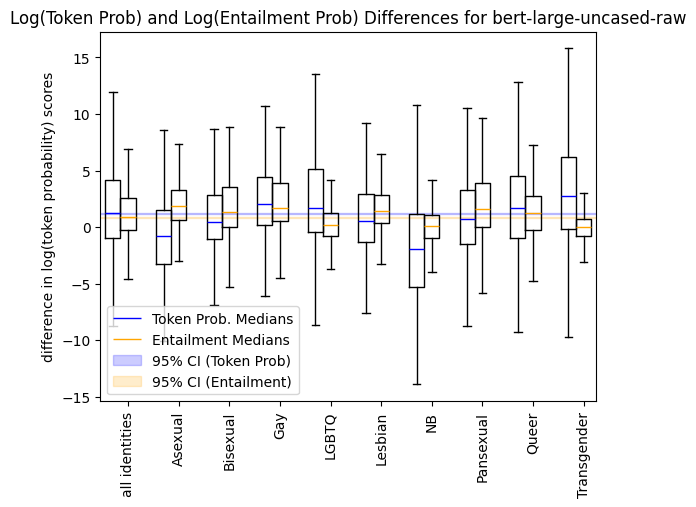

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


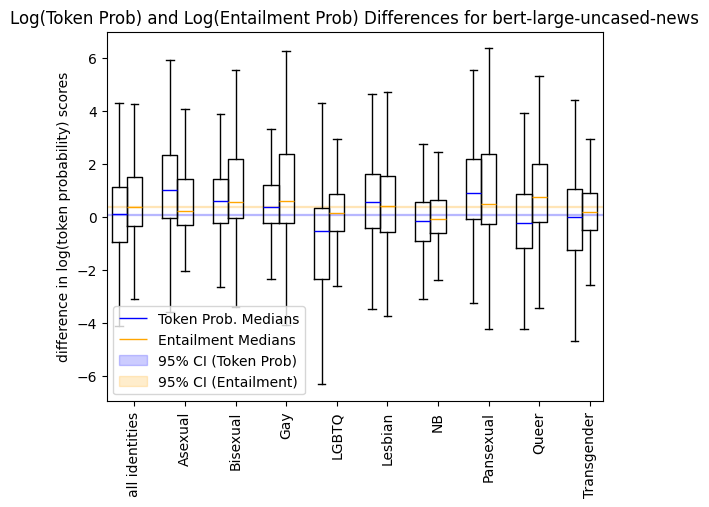

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


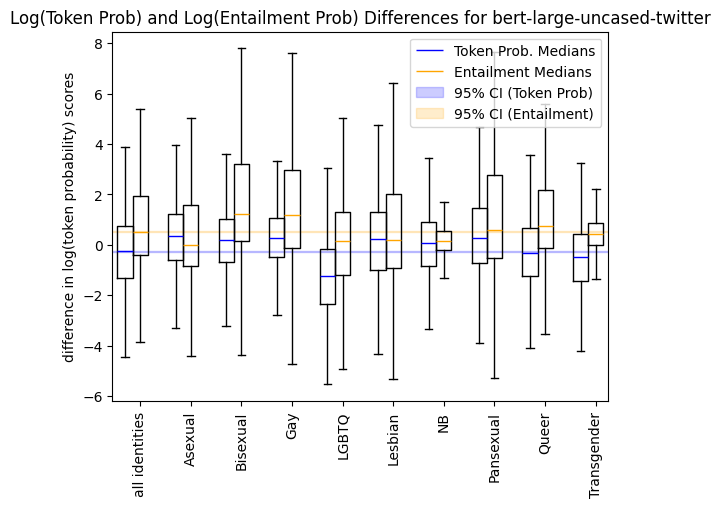

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


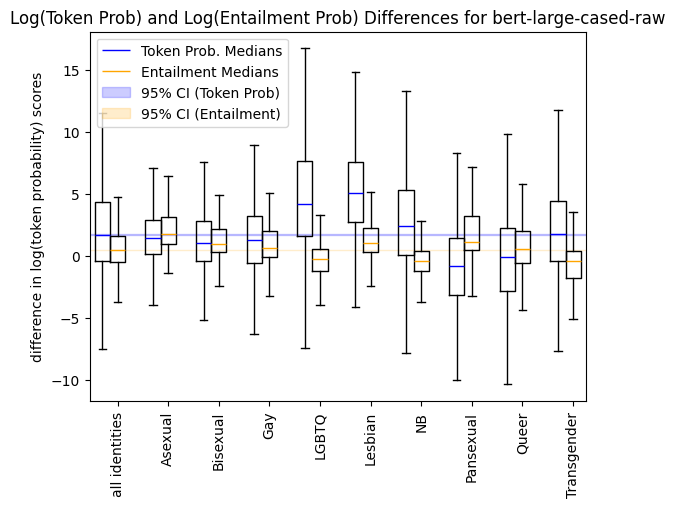

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


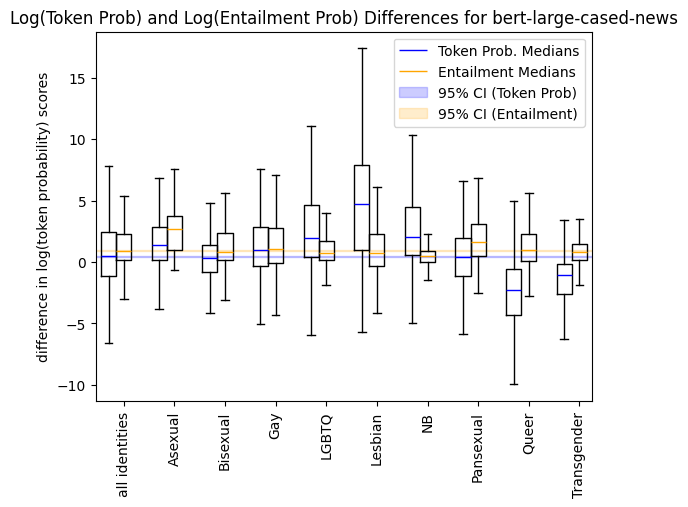

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


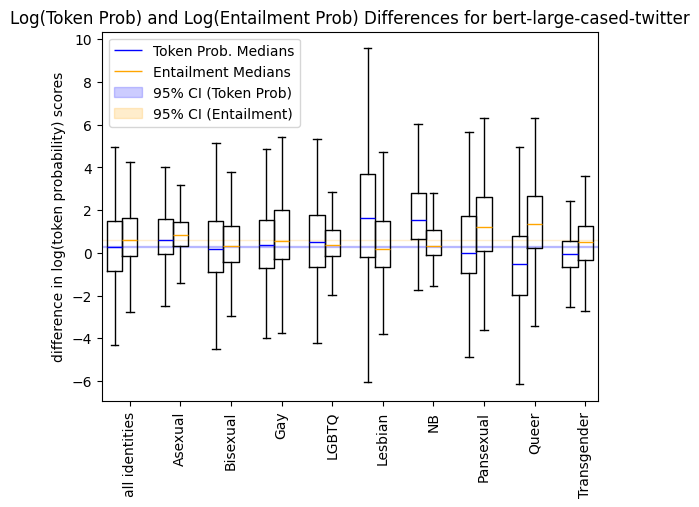

In [ ]:
# side by side boxplots - identity groups - BERT
# BERT Base Uncased
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_bert_base_uncased_raw.csv', '../data/wq_nli_results/BBU_raw_wqnli_results.csv', 'bert-base-uncased-raw')
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_bert_base_uncased_news.csv', '../data/wq_nli_results/BBU_news_wqnli_results.csv', 'bert-base-uncased-news')
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_bert_base_uncased_twitter.csv', '../data/wq_nli_results/BBU_tw_wqnli_results.csv', 'bert-base-uncased-twitter')

# BERT Base Cased
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_bert_base_cased_raw.csv', '../data/wq_nli_results/BBC_raw_wqnli_results.csv', 'bert-base-cased-raw')
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_bert_base_cased_news.csv', '../data/wq_nli_results/BBC_news_wqnli_results.csv', 'bert-base-cased-news')
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_bert_base_cased_twitter.csv', '../data/wq_nli_results/BBC_tw_wqnli_results.csv', 'bert-base-cased-twitter')

# BERT Large Uncased
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_bert_large_uncased_raw.csv', '../data/wq_nli_results/BLU_raw_wqnli_results.csv', 'bert-large-uncased-raw')
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_bert_large_uncased_news.csv', '../data/wq_nli_results/BLU_news_wqnli_results.csv', 'bert-large-uncased-news')
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_bert_large_uncased_twitter.csv', '../data/wq_nli_results/BLU_tw_wqnli_results.csv', 'bert-large-uncased-twitter')

# BERT Large Cased
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_bert_large_cased_raw.csv', '../data/wq_nli_results/BLC_raw_wqnli_results.csv', 'bert-large-cased-raw')
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_bert_large_cased_news.csv', '../data/wq_nli_results/BLC_news_wqnli_results.csv', 'bert-large-cased-news')
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_bert_large_cased_twitter.csv', '../data/wq_nli_results/BLC_tw_wqnli_results.csv', 'bert-large-cased-twitter')

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


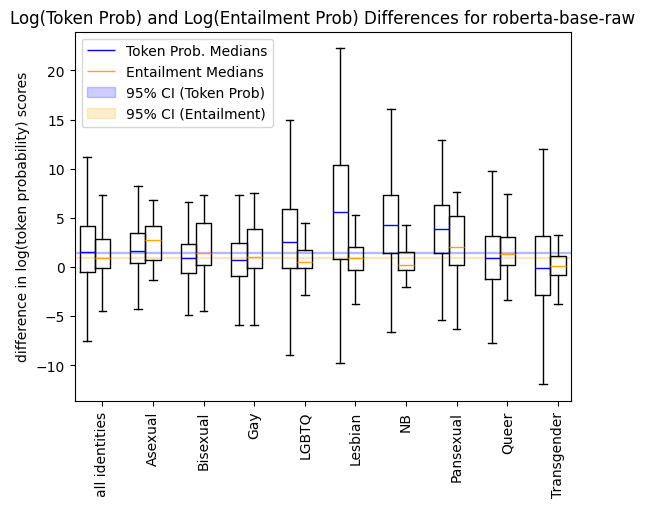

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


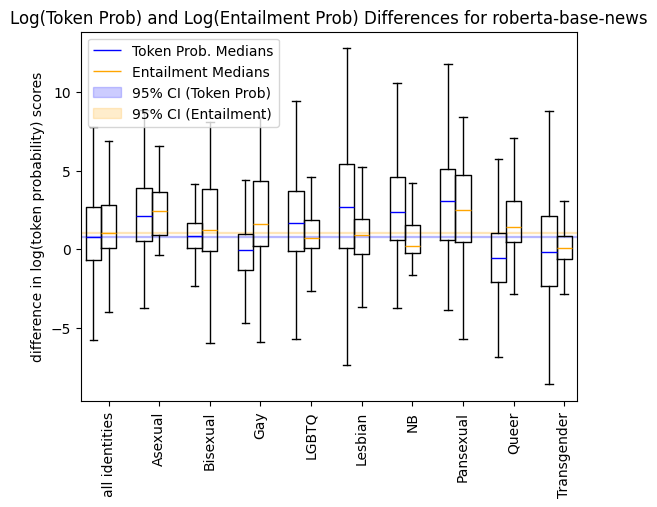

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


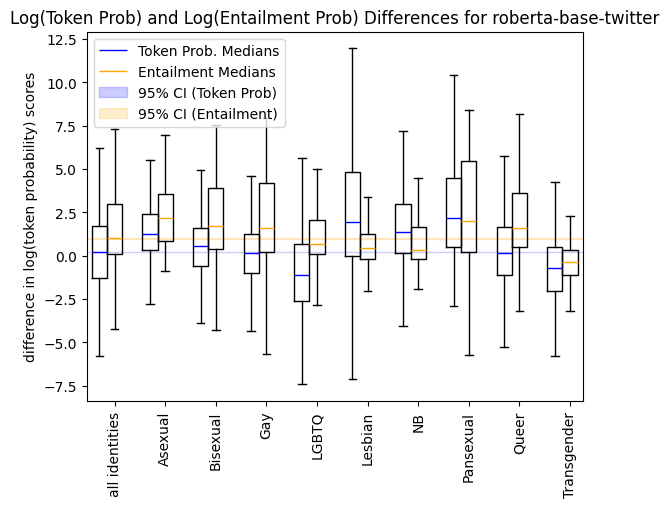

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


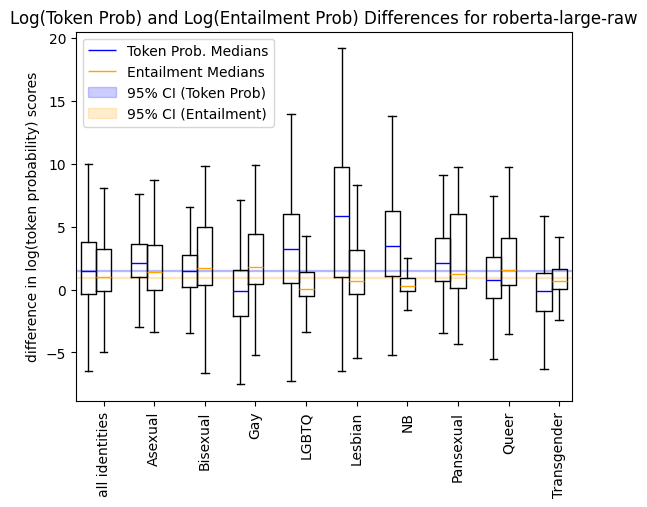

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


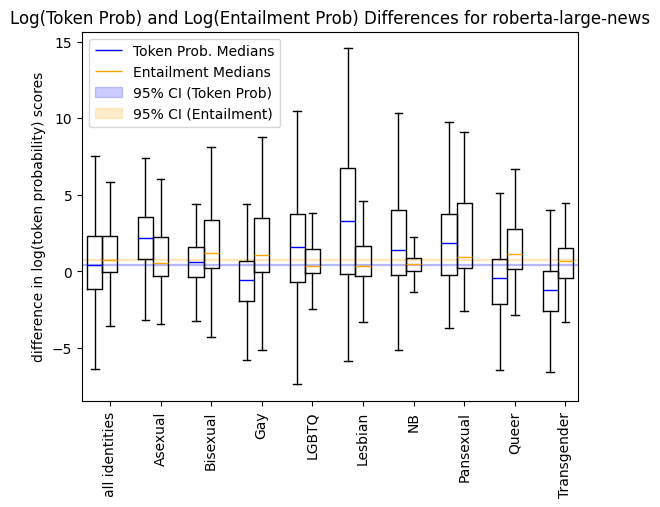

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


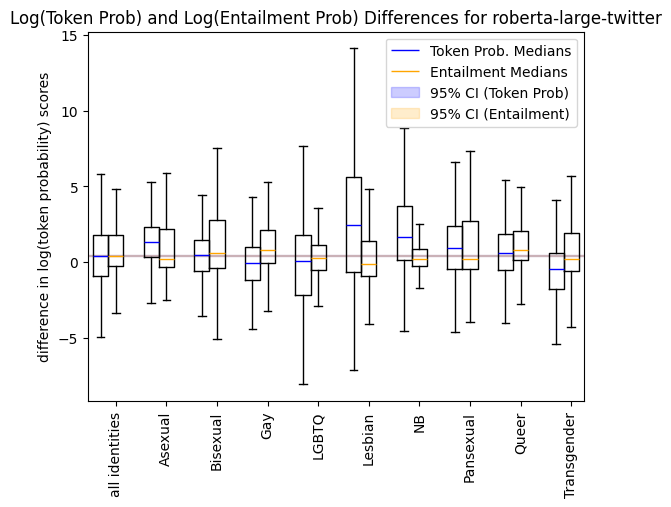

In [ ]:
# side by side boxplots - ID groups - RoBERTa
# RoBERTa Base
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_roberta_base_raw.csv', '../data/wq_nli_results/RB_raw_wqnli_results.csv', 'roberta-base-raw')
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_roberta_base_news.csv', '../data/wq_nli_results/RB_news_wqnli_results.csv', 'roberta-base-news')
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_roberta_base_twitter.csv', '../data/wq_nli_results/RB_twitter_wqnli_results.csv', 'roberta-base-twitter')

# RoBERTa Large
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_roberta_large_raw.csv', '../data/wq_nli_results/RL_raw_wqnli_results.csv', 'roberta-large-raw')
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_roberta_large_news.csv', '../data/wq_nli_results/RL_news_wqnli_results.csv', 'roberta-large-news')
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_roberta_large_twitter.csv', '../data/wq_nli_results/RL_twitter_wqnli_results.csv', 'roberta-large-twitter')

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


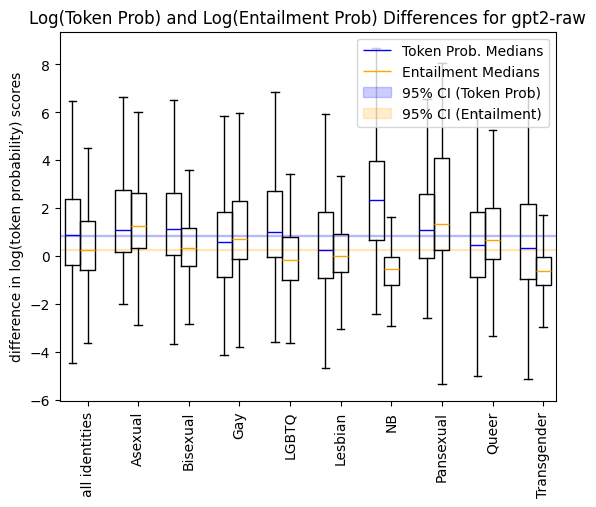

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


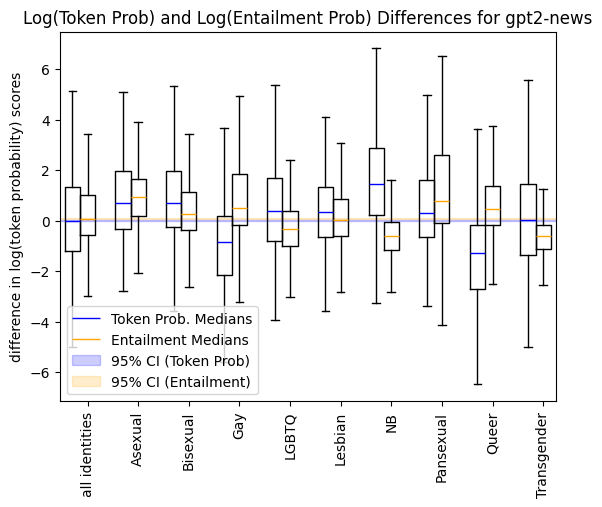

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


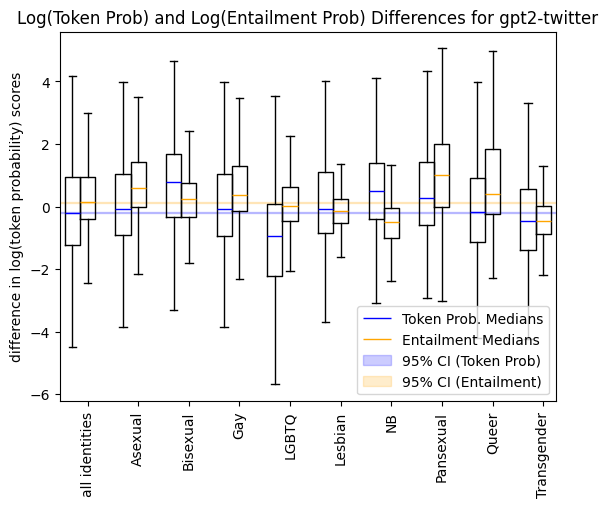

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


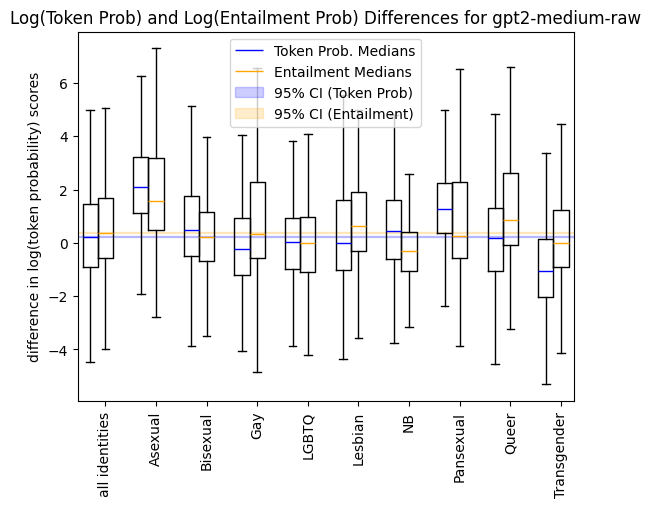

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


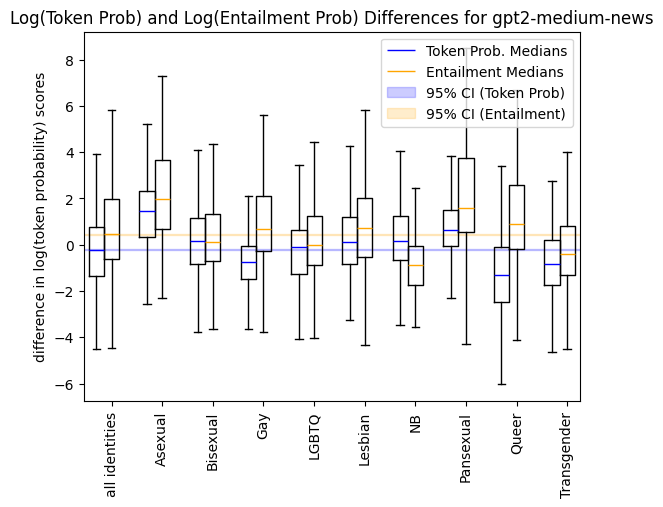

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


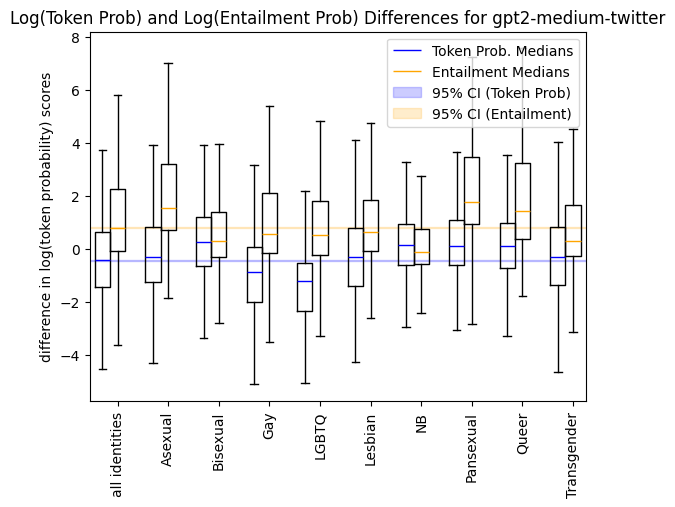

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


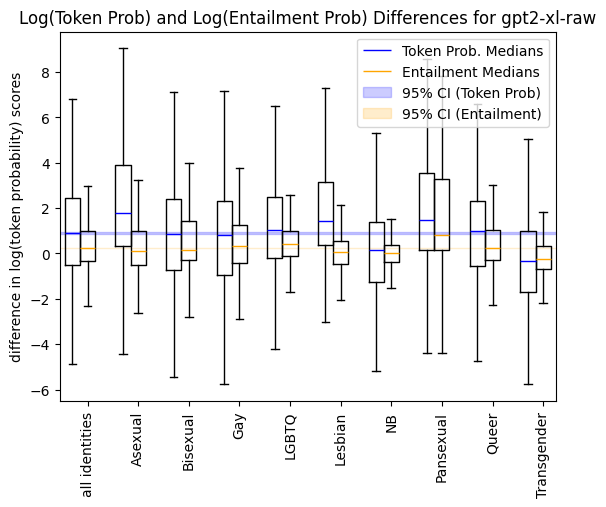

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


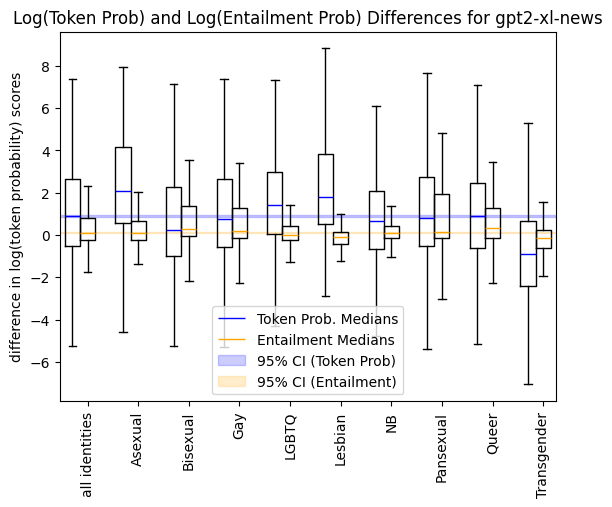

Identity groups found: ['LGBTQ', 'Queer', 'Transgender', 'Bisexual', 'Pansexual', 'Lesbian', 'Asexual', 'Gay', 'NB']


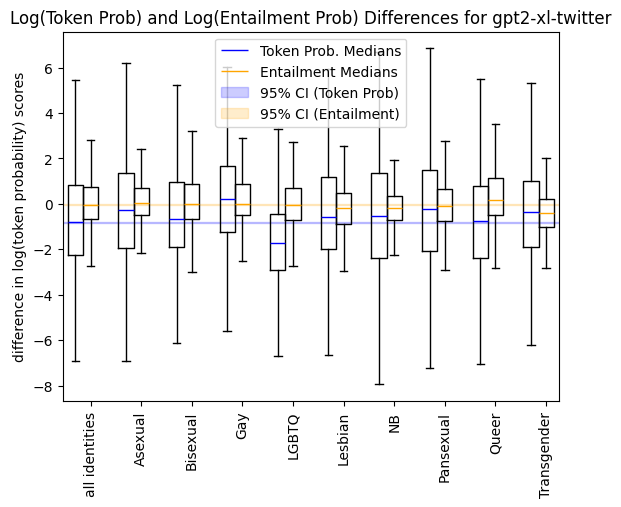

In [ ]:
# side by side boxplots - ID groups - GPT-2
# GPT-2
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_gpt2_raw.csv', '../data/wq_nli_results/GPT2_results.csv', 'gpt2-raw')
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_gpt2_news.csv', '../data/wq_nli_results/GPT2_News_results.csv', 'gpt2-news')
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_gpt2_twitter.csv', '../data/wq_nli_results/GPT2_Twitter_results.csv', 'gpt2-twitter')

# GPT-2 Medium
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_gpt2_medium_raw.csv', '../data/wq_nli_results/GPT2Medium_results.csv', 'gpt2-medium-raw')
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_gpt2_medium_news.csv', '../data/wq_nli_results/GPT2Medium_News_results.csv', 'gpt2-medium-news')
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_gpt2_medium_twitter.csv', '../data/wq_nli_results/GPT2Medium_Twitter_results.csv', 'gpt2-medium-twitter')

# GPT-2 XL
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_gpt2_xl_raw.csv', '../data/wq_nli_results/GPT2XL_results.csv', 'gpt2-xl-raw')
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_gpt2_xl_news.csv', '../data/wq_nli_results/GPT2XL_News_results.csv', 'gpt2-xl-news')
id_group_side_by_side_boxplot('../data/wq_tp_results/eval_gpt2_xl_twitter.csv', '../data/wq_nli_results/GPT2XL_Twitter_results.csv', 'gpt2-xl-twitter')

In [ ]:
# abstract out data preprocessing
def match_preds_token_prob(csv_path_token_prob):
    # load data
    df_token_probs = pd.read_csv(csv_path_token_prob)
    df_token_probs['score_diff'] = df_token_probs['sent_more_score'] - df_token_probs['sent_less_score']
    
    # token prob predicate matching
    match_df_token_probs = pd.read_csv('../data/datasets_with_metadata/winoqueer_final_with_preds.csv')
    match_df_token_probs['pred_number'] = match_df_token_probs['pred_number'].astype('Int64')
    match_df_token_probs['category_num'] = match_df_token_probs['category_num'].astype('Int64')
    match_df_token_probs = match_df_token_probs.drop(columns=['Unnamed: 0'])
    # join token prob results with predicate label DF
    joined_results_token_prob = df_token_probs.merge(match_df_token_probs, left_index=True, right_index=True, how='inner', validate='1:1')
    joined_results_token_prob = joined_results_token_prob.drop(columns=['Unnamed: 0', 'sent_x', 'sent_y', 'Gender_ID_x', 'Gender_ID_y'])
    # reorder columns
    joined_results_token_prob = joined_results_token_prob[['sent_more', 'sent_less', 'bias_target_group',
                                             'pred_number', 'pred_text', 'category_num', 'category', 
                                             'sent_more_score', 'sent_less_score', 'score', 'score_diff']]
    # drop rows with NaN values in 'pred_number' and 'category_num' columns
    joined_results_token_prob = joined_results_token_prob.dropna(subset=['pred_number', 'category_num', 'pred_text', 'category'])

    return joined_results_token_prob

def match_preds_entail(csv_path_entail):
    df_entail = pd.read_csv(csv_path_entail)
    df_entail['log(p(entail|stereo))'] = df_entail['p(entail|stereo)'].apply(np.log)
    df_entail['log(p(entail|counter))'] = df_entail['p(entail|counter)'].apply(np.log)
    df_entail['log_prob_diff'] = df_entail['log(p(entail|stereo))'] - df_entail['log(p(entail|counter))']

    match_df = pd.read_csv('../data/datasets_with_metadata/winoqueer_nli_with_preds.csv')
    match_df['pred_number'] = match_df['pred_number'].astype('Int64')
    match_df['category_num'] = match_df['category_num'].astype('Int64')
    match_df = match_df.drop(columns=['Unnamed: 0'])

     # join entailment results with predicate label DF
    joined_results_entail = df_entail.merge(match_df, left_index=True, right_index=True, how='inner', validate='1:1')
    joined_results_entail = joined_results_entail.drop(columns=['Unnamed: 0', 'stereo_premise_y', 'counter_premise_y', 'hypothesis_y'])
    # standardize column names
    joined_results_entail = joined_results_entail.rename(columns={
        'stereo_premise_x': 'stereo_premise',
        'counter_premise_x': 'counter_premise',
        'hypothesis_x': 'hypothesis'
    })
    # reorder columns
    joined_results_entail = joined_results_entail[['stereo_premise', 'counter_premise', 'hypothesis', 
                                               'pred_number', 'pred_text', 'category_num', 'category', 
                                               'p(entail|stereo)', 'p(neutral|stereo)', 'p(contradict|stereo)', 
                                               'p(entail|counter)', 'p(neutral|counter)', 'p(contradict|counter)',
                                               'log(p(entail|stereo))', 'log(p(entail|counter))', 'log_prob_diff']]

    # drop rows with NaN values in 'pred_number' and 'category_num' columns
    joined_results_entail = joined_results_entail.dropna(subset=['pred_number', 'category_num', 'pred_text', 'category'])

    return joined_results_entail



In [ ]:
# improved boxplots for paper figure
# want selected categories (all, drug use, naturalness/normalness, and sensitivity/emotion/attention-seeking)
# within each category, have TP and NLI separated by color
# then, within each eval setup, have raw/news/twitter

def selected_categories_boxplot(csv_path_tp_raw, csv_path_entail_raw, csv_path_tp_news, csv_path_entail_news, csv_path_tp_twitter, csv_path_entail_twitter, model_name):
    
    # color constants - declared up here for easy changing
    TOKEN_PROB_COLOR = 'magenta'
    ENTAIL_COLOR = 'green'
    BPLOT_ALPHA = 0.4
    TOKEN_PROB_COLOR_ALPHA = mcolors.to_rgba(TOKEN_PROB_COLOR, alpha=BPLOT_ALPHA)
    ENTAIL_COLOR_ALPHA = mcolors.to_rgba(ENTAIL_COLOR, alpha=BPLOT_ALPHA)

    # preprocess data
    results_tp_raw = match_preds_token_prob(csv_path_tp_raw)
    results_entail_raw = match_preds_entail(csv_path_entail_raw)
    results_tp_news = match_preds_token_prob(csv_path_tp_news)
    results_entail_news = match_preds_entail(csv_path_entail_news)
    results_tp_twitter = match_preds_token_prob(csv_path_tp_twitter)
    results_entail_twitter = match_preds_entail(csv_path_entail_twitter)

    # calculate CIs
    RNG_SEED = 1701
    # confidence interval for token prob
    ci_tp= stats.bootstrap((results_tp_raw['score_diff'],),
                         np.median, confidence_level=0.95, n_resamples=10000, method='basic', random_state=RNG_SEED)
    # confidence interval for entailment
    ci_entail = stats.bootstrap((results_entail_raw['log_prob_diff'],),
                         np.median, confidence_level=0.95, n_resamples=10000, method='basic', random_state=RNG_SEED)


    selected_cats = ['naturalness/normalness', 'drug use']
    cat_labels = ['all categories'] + selected_cats
    cats_tp_raw = [results_tp_raw['score_diff']]
    cats_entail_raw = [results_entail_raw['log_prob_diff']]
    cats_tp_news = [results_tp_news['score_diff']]
    cats_entail_news = [results_entail_news['log_prob_diff']]
    cats_tp_twitter = [results_tp_twitter['score_diff']]
    cats_entail_twitter = [results_entail_twitter['log_prob_diff']]
    for c in selected_cats:
        cats_tp_raw.append(results_tp_raw[results_tp_raw['category'] == c]['score_diff'].values)
        cats_entail_raw.append(results_entail_raw[results_entail_raw['category'] == c]['log_prob_diff'].values)
        cats_tp_news.append(results_tp_news[results_tp_news['category'] == c]['score_diff'].values)
        cats_entail_news.append(results_entail_news[results_entail_news['category'] == c]['log_prob_diff'].values)
        cats_tp_twitter.append(results_tp_twitter[results_tp_twitter['category'] == c]['score_diff'].values)
        cats_entail_twitter.append(results_entail_twitter[results_entail_twitter['category'] == c]['log_prob_diff'].values)


    fig, ax1 = plt.subplots()
    fig.set_size_inches(10, 6)
    
    # token prob box plots 
    bplot_tp_raw = ax1.boxplot(cats_tp_raw, widths=0.2, positions=[2*x - 0.6 for x in range(len(cat_labels))], sym='', patch_artist=True) # need x offset for side-by-side
    bplot_tp_news = ax1.boxplot(cats_tp_news, widths=0.2, positions=[2*x - 0.4 for x in range(len(cat_labels))], sym='', patch_artist=True) # need x offset for side-by-side
    bplot_tp_twitter = ax1.boxplot(cats_tp_twitter, widths=0.2, positions=[2*x - 0.2 for x in range(len(cat_labels))], sym='', patch_artist=True) # need x offset for side-by-side
    
    # patch artists for TP boxplots 
    for box in bplot_tp_raw['boxes']:
        box.set_facecolor(TOKEN_PROB_COLOR_ALPHA)

    for box in bplot_tp_news['boxes']:
        box.set_hatch('..')
        box.set_facecolor(TOKEN_PROB_COLOR_ALPHA)

    for box in bplot_tp_twitter['boxes']:
        box.set_hatch('//')
        box.set_facecolor(TOKEN_PROB_COLOR_ALPHA)


    ax1.set_ylabel('bias score(stereo) - bias score(counterstereo)')
    ax1.set_xticks([2*x for x in range(len(cat_labels))], labels=cat_labels, rotation=90)
    plt.setp(bplot_tp_raw['medians'], color=TOKEN_PROB_COLOR, linewidth=3)
    plt.setp(bplot_tp_news['medians'], color=TOKEN_PROB_COLOR, linewidth=3)
    plt.setp(bplot_tp_twitter['medians'], color=TOKEN_PROB_COLOR, linewidth=3)
    
    # add shaded area for 95% confidence interval
    lower_bound_token_prob, upper_bound_token_prob = ci_tp.confidence_interval
    token_prob_ci = ax1.axhspan(lower_bound_token_prob, upper_bound_token_prob, alpha=0.2, color=TOKEN_PROB_COLOR, label='95% CI (Token Prob)')
    
    # entailment box plots
    bplot_entail_raw = ax1.boxplot(cats_entail_raw, widths=0.2, positions=[2*x for x in range(len(cat_labels))], sym='', patch_artist=True) # need x offset for side-by-side
    bplot_entail_news = ax1.boxplot(cats_entail_news, widths=0.2, positions=[2*x + 0.2 for x in range(len(cat_labels))], sym='', patch_artist=True) # need x offset for side-by-side
    bplot_entail_twitter = ax1.boxplot(cats_entail_twitter, widths=0.2, positions=[2*x + 0.4 for x in range(len(cat_labels))], sym='', patch_artist=True) # need x offset for side-by-side


    # patch artists for entailment boxplots 
    for box in bplot_entail_raw['boxes']:
        box.set_facecolor(ENTAIL_COLOR_ALPHA)

    for box in bplot_entail_news['boxes']:
        box.set_hatch('..')
        box.set_facecolor(ENTAIL_COLOR_ALPHA)

    for box in bplot_entail_twitter['boxes']:
        box.set_hatch('//')
        box.set_facecolor(ENTAIL_COLOR_ALPHA)

    tick_labels = ['all categories', 'naturalness/normalness', 'drug use']
    
    ax1.set_xticks([2*x for x in range(len(cat_labels))], labels=tick_labels, rotation=0) 
    
    plt.setp(bplot_entail_raw['medians'], color=ENTAIL_COLOR, linewidth=3)
    plt.setp(bplot_entail_news['medians'], color=ENTAIL_COLOR, linewidth=3)
    plt.setp(bplot_entail_twitter['medians'], color=ENTAIL_COLOR, linewidth=3)

    
    # add shaded area for 95% confidence interval
    lower_bound_entail, upper_bound_entail = ci_entail.confidence_interval
    entailment_ci = ax1.axhspan(lower_bound_entail, upper_bound_entail, alpha=0.2, color=ENTAIL_COLOR, label='95% CI (Entailment)')
    
    plt.title(f'Debiasing Impact on Selected Categories for {model_name}')

    # legend
    plt.legend(handles=[bplot_tp_raw['boxes'][0], bplot_tp_news['boxes'][0], bplot_tp_twitter['boxes'][0],
                        bplot_entail_raw['boxes'][0], bplot_entail_news['boxes'][0], bplot_entail_twitter['boxes'][0]], 
               labels=['TP Raw (No Debiasing)', 'TP News-Debiased', 'TP Twitter-Debiased',
                       'Entailment Raw (No Debiasing)', 'Entailment News-Debiased', 'Entailment Twitter-Debiased'],
                loc='center left', bbox_to_anchor=(1, 0.8), handleheight=2)
    
    # callout arrows
    plt.annotate(
        '95% CI for TP Median,\nAll Categories, No Debiasing',  # Annotation text
        xy=(ax1.get_xlim()[1], upper_bound_token_prob),
        xycoords='data',
        xytext=(1.075, 0.4),
        textcoords='axes fraction', # Coordinate system for xytext
        arrowprops=dict(facecolor='black', shrink=0.05, headwidth=6, width=1), # Arrow properties 
        clip_on=False # Important: allows arrow to extend outside the plot area
    )
    plt.annotate(
        '95% CI for Entailment Median,\nAll Categories, No Debiasing',  # Annotation text
        xy=(ax1.get_xlim()[1], upper_bound_entail),
        xycoords='data',
        xytext=(1.075, 0.3),
        textcoords='axes fraction', # Coordinate system for xytext
        arrowprops=dict(facecolor='black', shrink=0.05, headwidth=6, width=1), # Arrow properties
        clip_on=False # Important: allows arrow to extend outside the plot area
    )
    #plt.tight_layout()

    # save to PNG
    plt.savefig(f'selected_categories_boxplot_{model_name}.png', bbox_inches='tight')
    plt.show()


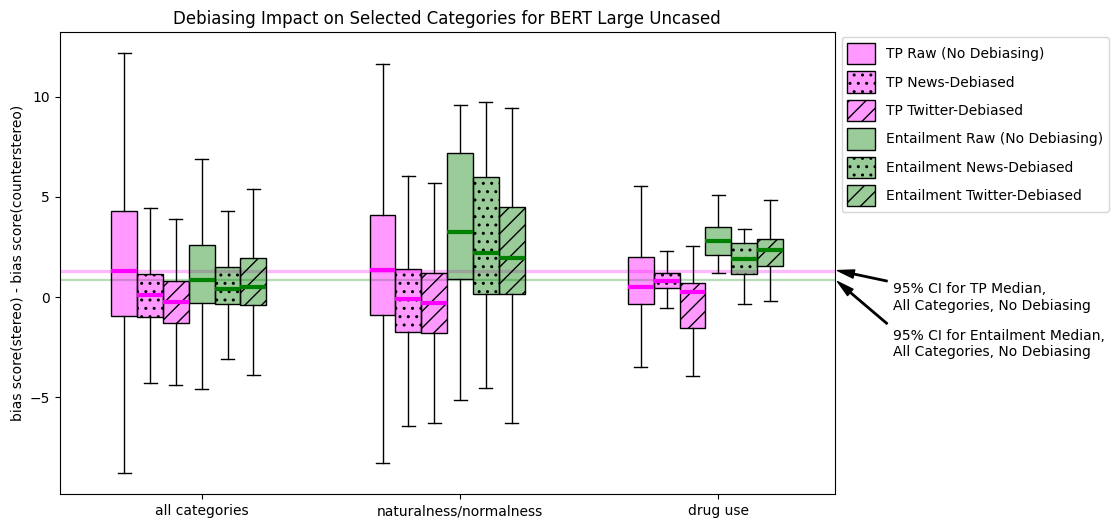

In [ ]:
selected_categories_boxplot('../data/wq_tp_results/eval_bert_large_uncased_raw.csv', '../data/wq_nli_results/BLU_raw_wqnli_results.csv', 
                            '../data/wq_tp_results/eval_bert_large_uncased_news.csv', '../data/wq_nli_results/BLU_news_wqnli_results.csv',
                            '../data/wq_tp_results/eval_bert_large_uncased_twitter.csv', '../data/wq_nli_results/BLU_twitter_wqnli_results.csv',
                            'BERT Large Uncased')

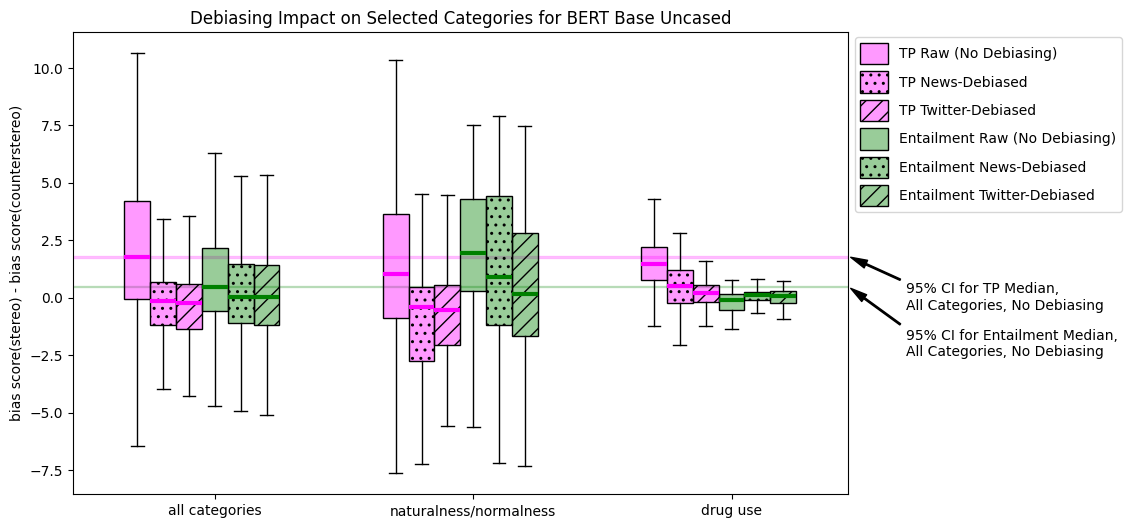

In [ ]:
selected_categories_boxplot('../data/wq_tp_results/eval_bert_base_uncased_raw.csv', '../data/wq_nli_results/BBU_raw_wqnli_results.csv', 
                            '../data/wq_tp_results/eval_bert_base_uncased_news.csv', '../data/wq_nli_results/BBU_news_wqnli_results.csv',
                            '../data/wq_tp_results/eval_bert_base_uncased_twitter.csv', '../data/wq_nli_results/BBU_twitter_wqnli_results.csv',
                            'BERT Base Uncased')

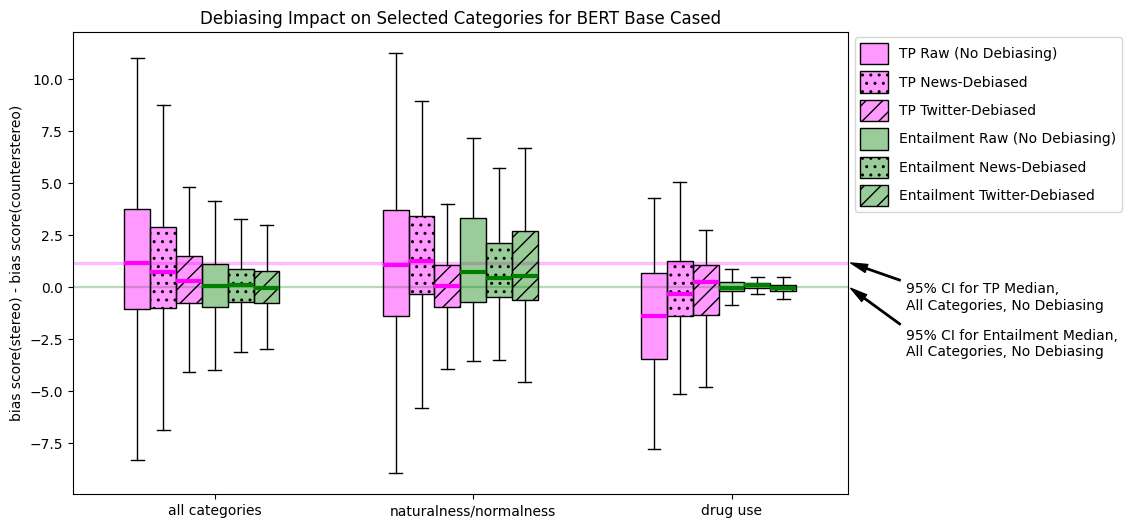

In [ ]:
selected_categories_boxplot('../data/wq_tp_results/eval_bert_base_cased_raw.csv', '../data/wq_nli_results/BBC_raw_wqnli_results.csv', 
                            '../data/wq_tp_results/eval_bert_base_cased_news.csv', '../data/wq_nli_results/BBC_news_wqnli_results.csv',
                            '../data/wq_tp_results/eval_bert_base_cased_twitter.csv', '../data/wq_nli_results/BBC_twitter_wqnli_results.csv',
                            'BERT Base Cased')

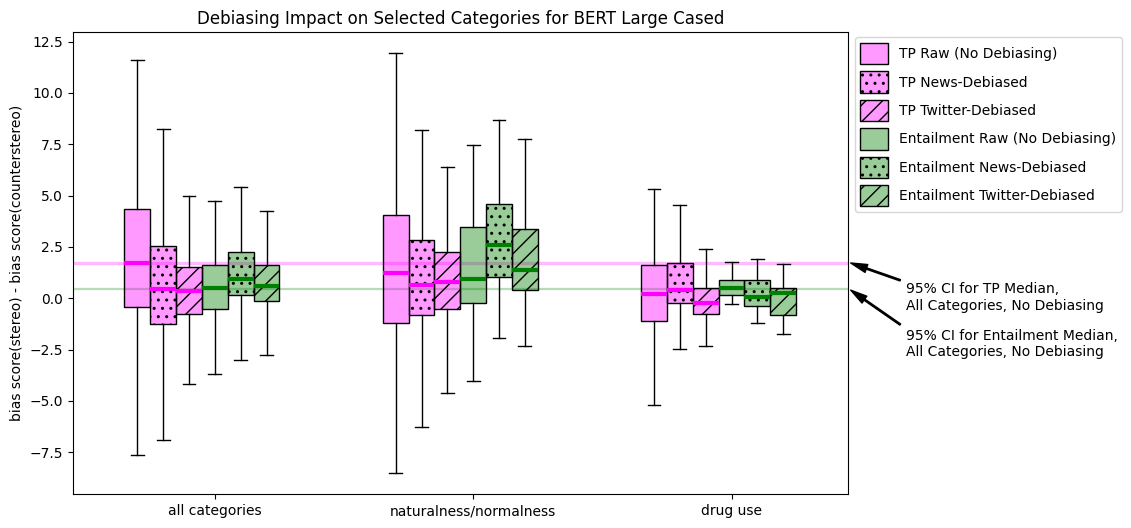

In [ ]:
selected_categories_boxplot('../data/wq_tp_results/eval_bert_large_cased_raw.csv', '../data/wq_nli_results/BLC_raw_wqnli_results.csv', 
                            '../data/wq_tp_results/eval_bert_large_cased_news.csv', '../data/wq_nli_results/BLC_news_wqnli_results.csv',
                            '../data/wq_tp_results/eval_bert_large_cased_twitter.csv', '../data/wq_nli_results/BLC_twitter_wqnli_results.csv',
                            'BERT Large Cased')

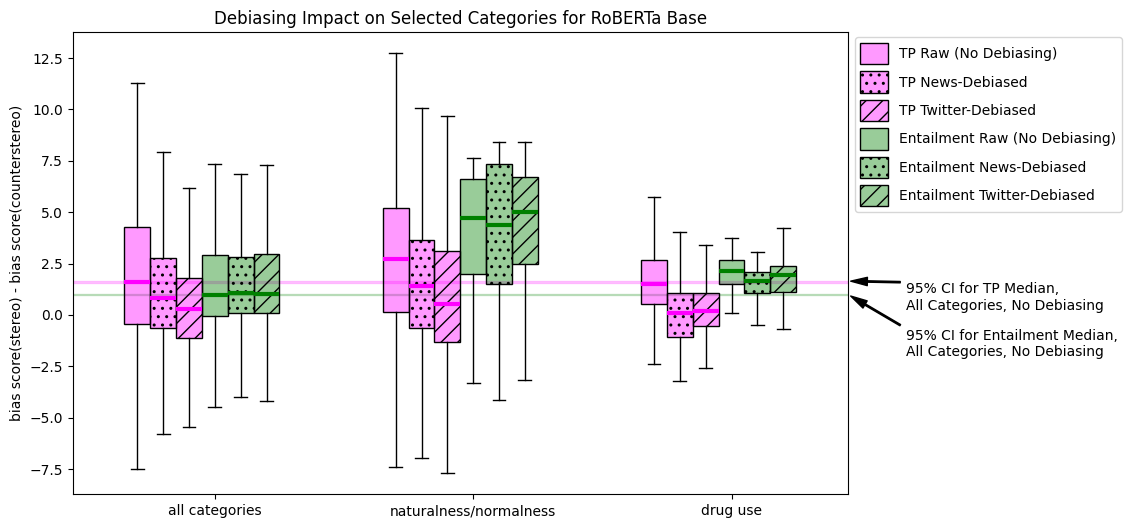

In [ ]:
selected_categories_boxplot('../data/wq_tp_results/eval_roberta_base_raw.csv', '../data/wq_nli_results/RB_raw_wqnli_results.csv', 
                            '../data/wq_tp_results/eval_roberta_base_news.csv', '../data/wq_nli_results/RB_news_wqnli_results.csv',
                            '../data/wq_tp_results/eval_roberta_base_twitter.csv', '../data/wq_nli_results/RB_twitter_wqnli_results.csv',
                            'RoBERTa Base')

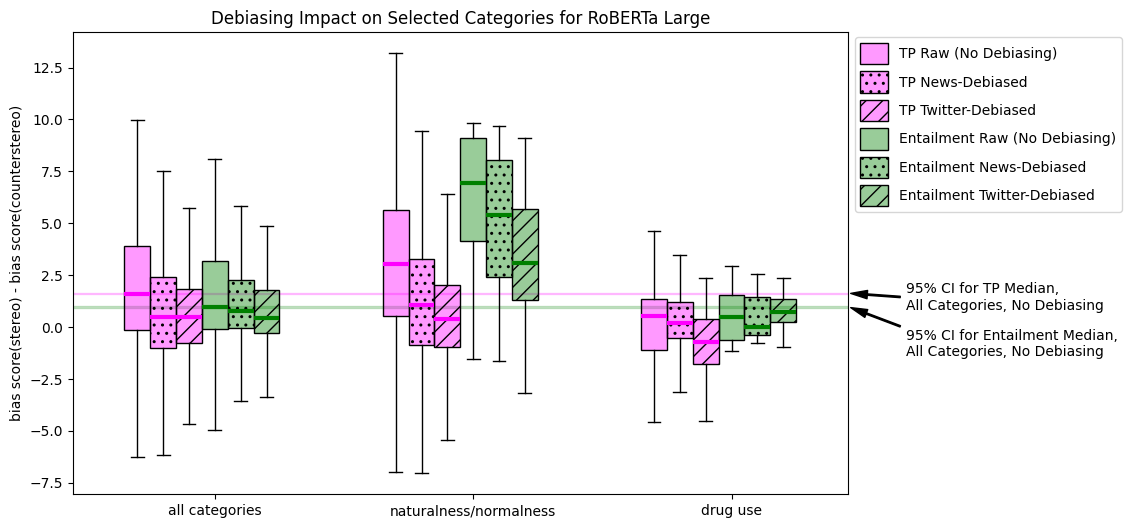

In [ ]:
selected_categories_boxplot('../data/wq_tp_results/eval_roberta_large_raw.csv', '../data/wq_nli_results/RL_raw_wqnli_results.csv', 
                            '../data/wq_tp_results/eval_roberta_large_news.csv', '../data/wq_nli_results/RL_news_wqnli_results.csv',
                            '../data/wq_tp_results/eval_roberta_large_twitter.csv', '../data/wq_nli_results/RL_twitter_wqnli_results.csv',
                            'RoBERTa Large')

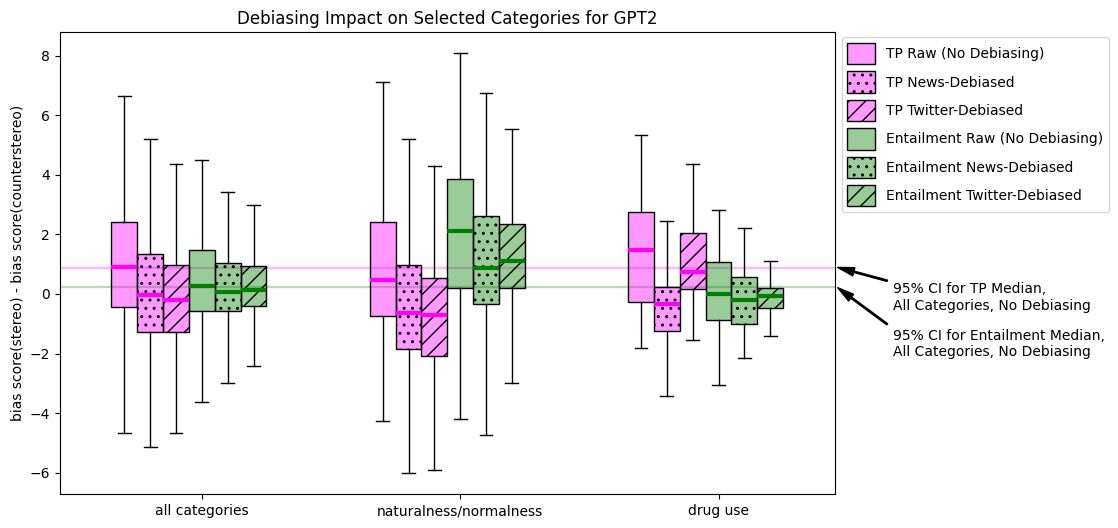

In [ ]:
selected_categories_boxplot('../data/wq_tp_results/eval_gpt2_raw.csv', '../data/wq_nli_results/GPT2_raw_wqnli_results.csv', 
                            '../data/wq_tp_results/eval_gpt2_news.csv', '../data/wq_nli_results/GPT2_news_wqnli_results.csv',
                            '../data/wq_tp_results/eval_gpt2_twitter.csv', '../data/wq_nli_results/GPT2_twitter_wqnli_results.csv',
                            'GPT2')

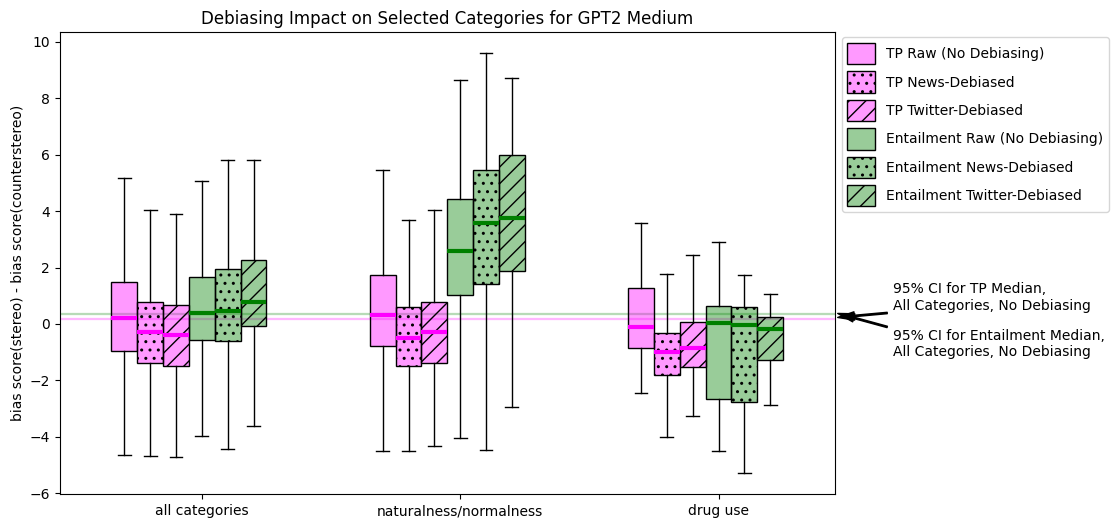

In [ ]:
selected_categories_boxplot('../data/wq_tp_results/eval_gpt2_medium_raw.csv', '../data/wq_nli_results/GPT2Medium_raw_wqnli_results.csv', 
                            '../data/wq_tp_results/eval_gpt2_medium_news.csv', '../data/wq_nli_results/GPT2Medium_news_wqnli_results.csv',
                            '../data/wq_tp_results/eval_gpt2_medium_twitter.csv', '../data/wq_nli_results/GPT2Medium_twitter_wqnli_results.csv',
                            'GPT2 Medium')

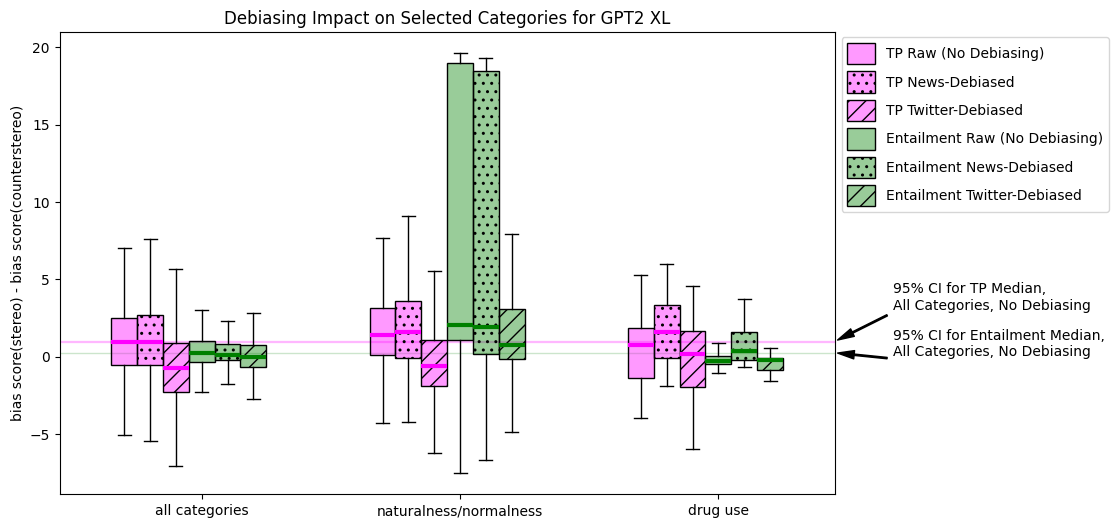

In [ ]:
selected_categories_boxplot('../data/wq_tp_results/eval_gpt2_xl_raw.csv', '../data/wq_nli_results/GPT2XL_raw_wqnli_results.csv', 
                            '../data/wq_tp_results/eval_gpt2_xl_news.csv', '../data/wq_nli_results/GPT2XL_news_wqnli_results.csv',
                            '../data/wq_tp_results/eval_gpt2_xl_twitter.csv', '../data/wq_nli_results/GPT2XL_twitter_wqnli_results.csv',
                            'GPT2 XL')